# Which factors are most predictive of the length of stay following major surgery? We will use a dataset containing demographic, medical and procedural data from patients who underwent colorectal surgery in a major US metropolitan hospital.

In [1]:
import numpy as np
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from patsy import dmatrix,dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm
import missingno as msno
from MissForestExtra import MissForestExtra as mfe
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold
from statsmodels.discrete.discrete_model import NegativeBinomial
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from missingpy import MissForest

In [2]:
colorectal_1 = pd.read_excel('/Users/jnl741/Downloads/Colorectal 10.28.16_final.xlsx')

In [3]:
colorectal_2 = pd.read_excel('/Users/jnl741/Downloads/Colon 10.29.21-6.24.22_final.xlsx')

In [4]:
"""Find common and distinct columns."""

colorectal_1_cols_list = colorectal_1.columns.to_list()
colorectal_2_cols_list = colorectal_2.columns.to_list()

missing_cols_colorectal_1 = []
missing_cols_colorectal_2 = []
common_cols = []
for col in colorectal_1_cols_list:
    if col in colorectal_2_cols_list:
        common_cols.append(col)
    else:
        missing_cols_colorectal_2.append(col)
for col in colorectal_2:
    if col not in common_cols:
        missing_cols_colorectal_1.append(col)
 

In [5]:
missing_cols_colorectal_1

['GS (>75) Home Origin Status - Support',
 'Case Acuity',
 'Operative Approach',
 'Robot Used',
 'Hand/Open Assist',
 'Unplanned Conversion to Open',
 'Preop Acute Kidney Injury',
 'Most Severe Preop Creatinine Increase',
 'Lowest Preop Urine Output',
 'Preop Dialysis',
 '# of Postop Renal Insufficiency',
 'Most Severe Postop Creatinine Increase',
 'Lowest Postop Urine Output',
 '# of Postop Dialysis',
 '# of Postop Venous Thrombosis Requiring Therapy']

In [6]:
missing_cols_colorectal_2

['GS (<75) Home Origin Status - Support',
 'Case Status',
 'Acute Renal Failure',
 'Currently requiring or on dialysis',
 '# of Postop Progressive Renal Insufficiency',
 '# of Postop Acute Renal Failure',
 '# of Postop Vein Thrombosis Requiring Therapy',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel Unknown',
 'Colectomy Mechanical Bowel Prep',
 'Colectomy Mechanical Bowel Prep Unknown',
 'Colectomy Oral Antibiotic Prep',
 'Colectomy Oral Antibiotic Prep Unknown',
 'Colectomy Chemotherapy w/in 90 days',
 'Colectomy Chemotherapy w/in 90 days Unknown',
 'Colectomy Primary Indication for Surgery',
 'Colectomy Non-Emergent Indication ICD9 Code',
 'Colectomy Non-Emergent Indication ICD10 Code',
 'Colectomy Indication for Surgery if Emergent',
 'Colectomy Emergent Indication ICD9 Code',
 'Colectomy Emergent Indication ICD10 Code',
 'Colectomy Operative Approach',
 'Colectomy Malignancy, Pathologic T Stage',
 'Colec

In [7]:
"""Looks like these features are common to both datasets, but inconsistently named: 

'GS (<75) Home Origin Status - Support'
'Colectomy Operative Approach'
'# of Postop Vein Thrombosis Requiring Therapy'
'Case Acuity'

Let's correct those inconsistencies."""

colorectal_1.rename(columns = {'GS (<75) Home Origin Status - Support':'GS (>75) Home Origin Status - Support',
                               'Colectomy Operative Approach':'Operative Approach',
                               '# of Postop Vein Thrombosis Requiring Therapy':'# of Postop Venous Thrombosis Requiring Therapy', 
                               'Case Status': 'Case Acuity'},
                                inplace = True)


In [8]:
"""Find common and distinct columns."""

colorectal_1_cols_list = colorectal_1.columns.to_list()
colorectal_2_cols_list = colorectal_2.columns.to_list()

missing_cols_colorectal_1 = []
missing_cols_colorectal_2 = []
common_cols = []
for col in colorectal_1_cols_list:
    if col in colorectal_2_cols_list:
        common_cols.append(col)
    else:
        missing_cols_colorectal_2.append(col)
for col in colorectal_2:
    if col not in common_cols:
        missing_cols_colorectal_1.append(col)

In [9]:
missing_cols_colorectal_1

['Robot Used',
 'Hand/Open Assist',
 'Unplanned Conversion to Open',
 'Preop Acute Kidney Injury',
 'Most Severe Preop Creatinine Increase',
 'Lowest Preop Urine Output',
 'Preop Dialysis',
 '# of Postop Renal Insufficiency',
 'Most Severe Postop Creatinine Increase',
 'Lowest Postop Urine Output',
 '# of Postop Dialysis']

In [10]:
missing_cols_colorectal_2


['Acute Renal Failure',
 'Currently requiring or on dialysis',
 '# of Postop Progressive Renal Insufficiency',
 '# of Postop Acute Renal Failure',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel',
 'Colectomy Steroid/Immunosuppressant for Inflammatory Bowel Unknown',
 'Colectomy Mechanical Bowel Prep',
 'Colectomy Mechanical Bowel Prep Unknown',
 'Colectomy Oral Antibiotic Prep',
 'Colectomy Oral Antibiotic Prep Unknown',
 'Colectomy Chemotherapy w/in 90 days',
 'Colectomy Chemotherapy w/in 90 days Unknown',
 'Colectomy Primary Indication for Surgery',
 'Colectomy Non-Emergent Indication ICD9 Code',
 'Colectomy Non-Emergent Indication ICD10 Code',
 'Colectomy Indication for Surgery if Emergent',
 'Colectomy Emergent Indication ICD9 Code',
 'Colectomy Emergent Indication ICD10 Code',
 'Colectomy Malignancy, Pathologic T Stage',
 'Colectomy Malignancy, Pathologic N Stage',
 'Colectomy Malignancy, Pathologic M Stage',
 'Colectomy Number of Nodes Evaluated',
 'Colectomy Number

In [11]:
"""Merge the two datasets"""
merged_colorectal = pd.concat([colorectal_1, colorectal_2],axis = 0, ignore_index = True)
merged_colorectal = merged_colorectal[common_cols]
merged_colorectal.shape

(802, 193)

In [12]:
"""Replace spaces in column names with underscores"""
merged_colorectal.columns = merged_colorectal.columns.str.replace("#","Num")


In [13]:
pd.options.display.max_rows = 1000
merged_colorectal.isnull().sum()

IDN                                                                0
Case Number                                                        0
Completion Status                                                  0
LMRN                                                              10
Date of Birth                                                      0
Age at Time of Surgery                                             0
Sex                                                                0
Race                                                              17
Indicate Other Race                                              802
Hispanic Ethnicity                                                40
Preferred Language                                                42
CPT Code                                                           0
CPT Description                                                    0
Primary Procedure                                                196
In/Out-Patient Status             

In [14]:
"""Let's remove columns containing sensitive information to protect patient and hospital privacy"""

merged_colorectal_public = merged_colorectal.copy()
merged_colorectal_public.drop(['IDN',
                               'Case Number',
                               'LMRN',
                               'Date of Birth',
                               'Attending/Staff Surgeon',
                               'NPI',
                               'LCN',
                               'Hospital Admission Date',
                               'Operation Date',
                               'Date of Death',
                               'Date of First Readmission',
                               'Date  of First Unplanned Return to OR',
                               'Date of Second unplanned return',
                               'Contact: Phone',
                               'Contact: Letter',                                                 
                               'Contact: Email',                                                   
                               'Contact: Documentation',                                            
                               'Contact: Other',
                               'QITI Team',
                               'QITI Resident',
                               'QITI PGY',
                               'QITI COMMENTS'],
                                axis = 1,
                                inplace = True)


In [15]:
%%capture
merged_colorectal_public.to_csv('colorectal_data.csv')

In [16]:
"""Hospital_Length_of_Stay (LOS) is the column we're interested in modeling. Let's therefore remove any rows with 
missing LOS data. """

merged_colorectal['Hospital Length of Stay'].isnull().sum()



6

In [17]:
merged_colorectal = merged_colorectal[merged_colorectal['Hospital Length of Stay'].notnull()].reset_index()

In [18]:
"""Let's rename some lengthy column names"""

merged_colorectal = merged_colorectal.rename(columns = {"Age at Time of Surgery": 'Age',
                                            "Sepsis (SIRS/Sepsis/Septic shock) (48h)":'Sepsis',
                                            'Num of Postop Blood Transfusions (72h of surgery start time)':'Num of Postop Blood Transfusions',
                                            'Hemoglobin A1c (HbA1c)':'Hemoglobin A1c',
                                            'Preop RBC Transfusions (72h)': 'Preop RBC Transfusions'})

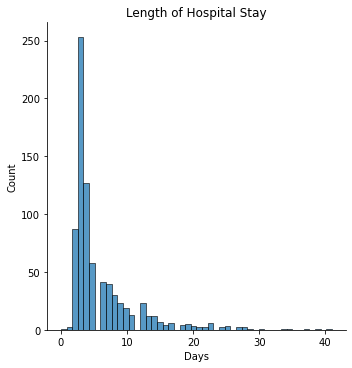

In [19]:
"""Let's start by examining the distribution of hospital length of stay."""

bins = int(np.sqrt(merged_colorectal.shape[0]))

sns.displot(merged_colorectal['Hospital Length of Stay'])
sns.despine()
plt.title('Length of Hospital Stay')
plt.xlabel('Days')
plt.show()

We have a distribution of counts, with a characteristic right skew, which is best fit by either a Poisson distribution
or a negative binomial distribution. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

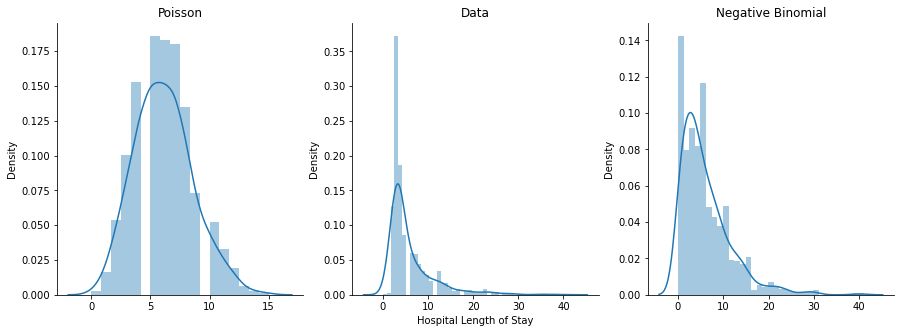

In [20]:
"""Let's generate simulated Poisson and negative binomial distributions based on parameters derived from our data.
The Poisson distribution has one parameter which describes both its mean and its variance. The binomial
distribution is overdispersed, such that the variance is a quadratic function of the mean and a dispersion parameter. 
Determinging which distribution best fits our data will aid our choice of model."""


# Simulated Poisson. The Poisson distribution has one parameter which describes both its mean and its variance
Poisson_sim = np.random.poisson(merged_colorectal['Hospital Length of Stay'].mean(),800)


# Simulate negative binomial distribution
mean = merged_colorectal['Hospital Length of Stay'].mean()
var = merged_colorectal['Hospital Length of Stay'].var()

n = mean**2 / (var - mean)
p = mean / var

NB_sim = np.random.negative_binomial(n,p,1000)

# plot distributions
fig, axes = plt.subplots(1,3, 
                         squeeze = False, 
                         figsize = (15,5))
sns.distplot(Poisson_sim, ax = axes[0][0])
axes[0][0].set_title('Poisson')
sns.distplot(merged_colorectal['Hospital Length of Stay'], ax = axes[0][1])
axes[0][1].set_title('Data')
sns.distplot(NB_sim, ax = axes[0][2])
axes[0][2].set_title('Negative Binomial')
sns.despine()
plt.show()

Both the Poisson and the negative binomial distributions peak around 5, with the majority of values falling between 1 and ~15, and have a rightward skew. However, the negative binomial distribution looks to be a better overall fit to the data, capturing more completely the tail than does the Poisson distribution. 

In [21]:
"""To further substantiate our choice of model, let's examine our target variable, length of stay (LOS), for over-
dispersion. To do that, we will fit a negative binomial distribution to our data without any predictors."""

x = np.ones_like(merged_colorectal['Hospital Length of Stay'])
nb_model = sm.NegativeBinomial(merged_colorectal['Hospital Length of Stay'],x).fit()
print(nb_model.summary())

Optimization terminated successfully.
         Current function value: 2.737435
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
                        NegativeBinomial Regression Results                        
Dep. Variable:     Hospital Length of Stay   No. Observations:                  796
Model:                    NegativeBinomial   Df Residuals:                      795
Method:                                MLE   Df Model:                            0
Date:                     Tue, 30 Aug 2022   Pseudo R-squ.:              -2.806e-11
Time:                             13:10:45   Log-Likelihood:                -2179.0
converged:                            True   LL-Null:                       -2179.0
Covariance Type:                 nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

Alpha is the overdispersion parameter, and is 0.3636 in our case. While small, the p-value indicates that it is statistically signigicant. We will therefore conclude that our data is more appropriately fit with a negative binomial distribution than a Poisson distribution.

In [22]:
%%capture

"""There appear to be four types of features in the dataset:

1) Demographic data: race, sex, age
2) Information about the surgery: open vs laproscopic, etc
3) Comorbidities, or diseases/ health conditions
4) Complications arising from the surgery

Let's perform some cleaning and EDA on each category."""

In [23]:
%%capture
"""Cleaning and EDA on surgery type. 'In/Out-Patient_Status and CPT_Description' appear to be relevant columns, and
do not suffer from substantial amounts of missing data."""

In [24]:
merged_colorectal['In/Out-Patient Status'].value_counts(dropna = False)

Inpatient     752
NaN            40
Outpatient      4
Name: In/Out-Patient Status, dtype: int64

Due to the substantial class imbalance, this feature will likely not be useful for modeling. 

In [25]:
"""CPT description"""

merged_colorectal['CPT Description'].value_counts(dropna = False)

Laparoscopy, surgical; colectomy, partial, with removal of terminal ileum with ileocolostomy                                                                                                               247
Laparoscopy, surgical; colectomy, partial, with anastomosis, with coloproctostomy (low pelvic anastomosis)                                                                                                 234
Laparoscopy, surgical; colectomy, partial, with anastomosis                                                                                                                                                101
Colectomy, partial, with removal of terminal ileum with ileocolostomy                                                                                                                                       52
Laparoscopy, surgical; colectomy, partial, with anastomosis, with coloproctostomy (low pelvic anastomosis) with colostomy                                                   

In [26]:
"""Open procedures involve making a single, large incision, and are the traditional surgical approach. Laparoscopic
surgery, in contrast, is a minimally invasive approach. It has been shown that recovery times are generally shorter
for laparoscopic procedures. 
Let's consolidate the column along an open or laparoscipic axis."""

merged_colorectal['Open or Laparoscopic'] =  np.where(merged_colorectal['CPT Description'].str.startswith('Laparoscopy'),
                                                     'Laparoscopic',
                                                     'Open')

In [27]:
merged_colorectal['Albumin']

0      2.1
1      4.3
2      4.6
3      NaN
4      4.2
5      2.9
6      4.7
7      4.2
8      2.3
9      4.4
10     4.1
11     4.3
12     4.4
13     4.7
14     4.3
15     3.7
16     4.7
17     4.0
18     4.5
19     4.2
20     3.5
21     4.1
22     3.6
23     3.6
24     4.3
25     4.7
26     3.5
27     4.9
28     4.0
29     4.3
30     4.7
31     4.1
32     4.4
33     3.6
34     3.9
35     4.2
36     5.0
37     4.4
38     4.5
39     4.3
40     4.5
41     4.0
42     4.6
43     4.2
44     4.0
45     4.8
46     4.3
47     4.0
48     3.0
49     3.5
50     4.3
51     4.6
52     4.7
53     4.4
54     3.5
55     4.3
56     3.8
57     4.0
58     3.8
59     2.9
60     NaN
61     4.6
62     4.9
63     4.2
64     3.0
65     2.6
66     3.9
67     4.4
68     NaN
69     3.9
70     4.2
71     4.7
72     4.1
73     NaN
74     4.1
75     4.1
76     4.4
77     4.8
78     3.8
79     4.7
80     4.3
81     4.0
82     4.4
83     4.6
84     4.4
85     2.9
86     NaN
87     4.4
88     3.8
89     3.7
90     4.3

In [28]:
merged_colorectal['Open or Laparoscopic'].value_counts(dropna = False)

Laparoscopic    671
Open            125
Name: Open or Laparoscopic, dtype: int64

<AxesSubplot:xlabel='Open or Laparoscopic', ylabel='Hospital Length of Stay'>

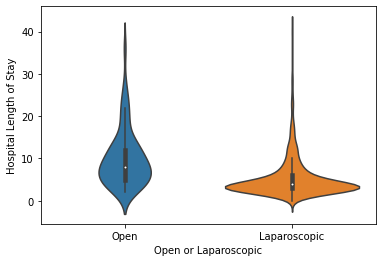

In [29]:
sns.violinplot(x = 'Open or Laparoscopic',
            y = 'Hospital Length of Stay',
            data = merged_colorectal)

In [30]:
"""Mann-Whitney U test comparison of median length of stay following open vs. laparoscopic colectomies."""

scipy.stats.mannwhitneyu(merged_colorectal[merged_colorectal['Open or Laparoscopic'] == 'Laparoscopic']['Hospital Length of Stay'],
                    merged_colorectal[merged_colorectal['Open or Laparoscopic'] == 'Open']['Hospital Length of Stay'])

MannwhitneyuResult(statistic=18645.5, pvalue=8.079463493939606e-24)

It appears as though patients undergoing laparoscopic colectomies have a statistically significant 
shorter length of stay.

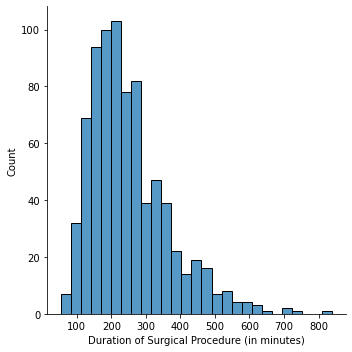

In [31]:
"""What does the distribution of surgery duration look like? """

sns.displot(x = 'Duration of Surgical Procedure (in minutes)',
            data = merged_colorectal)
sns.despine()

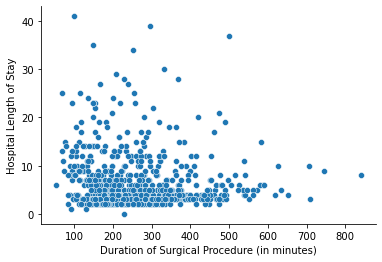

In [32]:
"""Is there an obvious relationship between duration of surgery and hospital length of stay?"""

sns.scatterplot(x = 'Duration of Surgical Procedure (in minutes)',
                 y = 'Hospital Length of Stay',
                 data = merged_colorectal)
sns.despine()

In [33]:
""" Let's quantify the correlation between duration of surgery and length of stay. Given the discrete, essentially 
ordinal nature of the length of stay variable, Kendall's tau, a rank-based test of correlation, is the appropriate 
choice."""

ktau = merged_colorectal['Duration of Surgical Procedure (in minutes)'].corr(merged_colorectal['Hospital Length of Stay'],
                                     method = 'kendall')
print(f" Kendall's tau correlation coefficient = {ktau}")

 Kendall's tau correlation coefficient = 0.03562191074018932


There is not a strong association between surgery duration and length of stay in our dataset. 

In [34]:
"""What is the breakdown of case acuity, that is, elective, urgent, or emergent, in our dataset? """
merged_colorectal['Case Acuity'].value_counts(dropna = False)

NaN         600
Elective    173
Urgent       15
Emergent      8
Name: Case Acuity, dtype: int64

In [35]:
merged_colorectal['Emergency Case'].value_counts(dropna = False)

No     600
NaN    196
Name: Emergency Case, dtype: int64

In [36]:
"""To restrict analysis to elective procedures, drop urgent cases."""

merged_colorectal[merged_colorectal['Emergency Case'].isnull()]['Elective Surgery'].value_counts(dropna = False)
merged_colorectal[merged_colorectal['Emergency Case'].isnull()]['Case Acuity'].value_counts(dropna = False)
merged_colorectal.drop(merged_colorectal[merged_colorectal['Case Acuity'] == 'Emergent'].index, inplace = True)

# Replace null values with 'Elective'
merged_colorectal.fillna(value = {'Case Acuity':'Elective'},inplace = True)
merged_colorectal['Case Acuity'].value_counts(dropna = False)


Elective    773
Urgent       15
Name: Case Acuity, dtype: int64

It looks like there are 773 elective cases, 15 urgent cases, and 8 emergent cases (which we dropped). Owing to this substantial class imbalance, it is unlikely that we can make any statistically significant inferences about differences in length of stay between these groups. We will therefore exclude this variable from further analysis.

In [37]:
"""To where were patients discharged, home, a nursing facility, etc.?"""

merged_colorectal['Hospital Discharge Destination'].value_counts(dropna = False)

Home                        537
Home/Permanent Residence    155
Skilled Care, Not Home       61
Other Facility               16
NaN                           9
Facility Which was Home       4
Expired                       3
Hospice                       2
Rehab                         1
Name: Hospital Discharge Destination, dtype: int64

The overwhelming majority of patients, 692/776, were discharged to their home/permanent residence, with the remaining
patients going to a smattering of other destinations. Owing to the substantial class imbalance, we will exlude this 
variable from further analysis.

In [38]:
""" Functional health status describes whether a patient is functionally independent, or requires assistance to perform
the daily activities of life. It is therefore a readout of overall health, and may be predictive of length of stay."""

# Fix the typo in the original column name
merged_colorectal.rename(columns = {'Functional Heath Status': 'Functional Health Status'}, inplace = True)

In [39]:
merged_colorectal['Functional Health Status'].value_counts(dropna = False)

Independent            730
Partially Dependent     46
Totally Dependent        6
Unknown                  3
NaN                      3
Name: Functional Health Status, dtype: int64

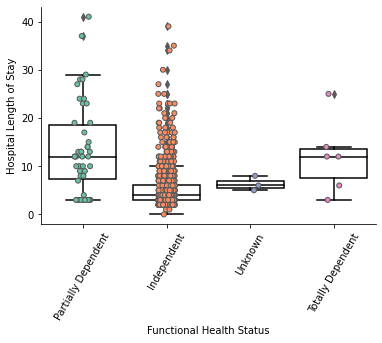

In [40]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Functional Health Status', 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'Functional Health Status', 
              y = 'Hospital Length of Stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [41]:
#Consolidate health status into functionally independent or dependent values

merged_colorectal['Functionally Indpdnt or Dpdnt'] = np.where(merged_colorectal['Functional Health Status'].isin(['Partially Dependent','Totally Dependent']),
                                                                                                                 'Dependent',
                                                                                                                 'Independent')

In [42]:
merged_colorectal['Functionally Indpdnt or Dpdnt'].value_counts(dropna = False)

Independent    736
Dependent       52
Name: Functionally Indpdnt or Dpdnt, dtype: int64

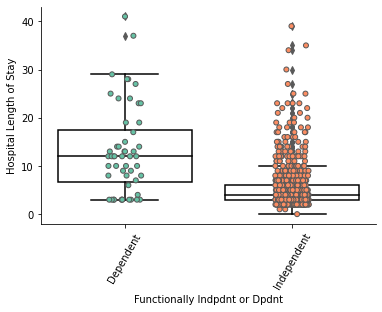

In [43]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Functionally Indpdnt or Dpdnt', 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'Functionally Indpdnt or Dpdnt', 
              y = 'Hospital Length of Stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [44]:
scipy.stats.mannwhitneyu(merged_colorectal[merged_colorectal['Functionally Indpdnt or Dpdnt']=='Dependent']['Hospital Length of Stay'], 
                        merged_colorectal[merged_colorectal['Functionally Indpdnt or Dpdnt']=='Independent']['Hospital Length of Stay'])

MannwhitneyuResult(statistic=29893.0, pvalue=4.572639037911581e-12)

It appears as though functional dependence is associated with a longer length of stay

In [45]:
"""On which day of the week were surgeries performed? This has shown to be a factor in determining length of stay."""

# Get the data type and format of the 'Operation_Date' column'
merged_colorectal['Operation Date'].head()

0    11/05/2016
1    11/08/2016
2    11/01/2016
3    11/01/2016
4    11/04/2016
Name: Operation Date, dtype: object

In [46]:
"""Create operation month and day-of-week columns"""

#Convert operation date column to datetime type
merged_colorectal['Operation Date'] = pd.to_datetime(merged_colorectal['Operation Date'])

#Extract month
merged_colorectal['Operation Month'] = merged_colorectal['Operation Date'].dt.month

# Create a dictionary to map numeric months to proper nouns (January, February, etc.)
months_dict = {i:j for i,j in enumerate(list(calendar.month_name)) if i != 0}
merged_colorectal['Operation Month'] = merged_colorectal['Operation Month'].map(months_dict)


# Repeat the above procedure for day of operation
merged_colorectal['Operation dow'] = merged_colorectal['Operation Date'].dt.dayofweek

days_dict = {i:j for i,j in enumerate(list(calendar.day_name))}
merged_colorectal['Operation dow'] = merged_colorectal['Operation dow'].map(days_dict)


In [47]:
dow = merged_colorectal.groupby(by = 'Operation dow')['Hospital Length of Stay'].agg([np.median,np.size])
dow = dow.reindex(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday'])
dow

median  size
Operation dow              
Monday            5.0    73
Tuesday           3.0   192
Wednesday         5.5    66
Thursday          4.0   237
Friday            4.0   207

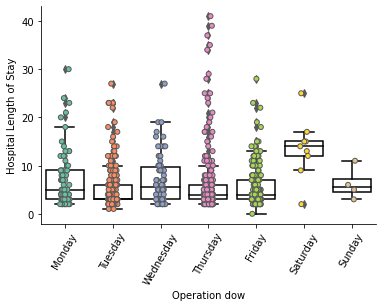

In [48]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Operation dow', 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
            order = [day for day in days_dict.values()])
sns.stripplot(x = 'Operation dow', 
              y = 'Hospital Length of Stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = [day for day in days_dict.values()],
              jitter = 0.1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [49]:
scipy.stats.kruskal(merged_colorectal[merged_colorectal['Operation dow'] == 'Monday']['Hospital Length of Stay'],
                   merged_colorectal[merged_colorectal['Operation dow'] == 'Tuesday']['Hospital Length of Stay'],
                   merged_colorectal[merged_colorectal['Operation dow'] == 'Wednesday']['Hospital Length of Stay'],
                   merged_colorectal[merged_colorectal['Operation dow'] == 'Thursday']['Hospital Length of Stay'],
                   merged_colorectal[merged_colorectal['Operation dow'] == 'Friday']['Hospital Length of Stay'])

KruskalResult(statistic=15.972860815188705, pvalue=0.003055797415789259)

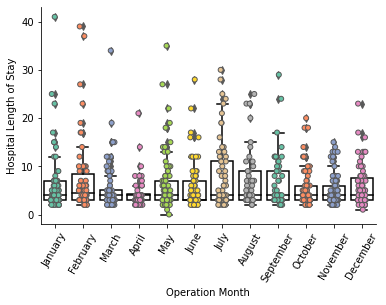

In [50]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Operation Month', 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2',
            order = [month for month in months_dict.values()])
sns.stripplot(x = 'Operation Month', 
              y = 'Hospital Length of Stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = [month for month in months_dict.values()],
              jitter = 0.15)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [51]:
%%capture
"""Cleaning and EDA on demographic features"""

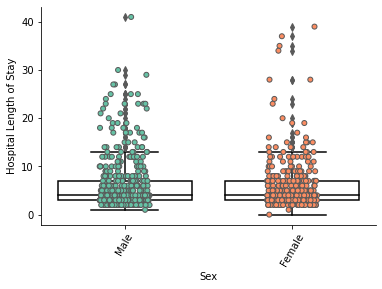

In [52]:
"""Is there a difference in length of stay between male and female patients?"""

props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Sex', 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'Sex', 
              y = 'Hospital Length of Stay', 
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              jitter = 0.15)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

There does not appear to be a difference in length of stay between the sexes

In [53]:
"""What is the racial makeup of the patient population?"""

merged_colorectal['Race'].value_counts(dropna = False)

Asian                               264
White                               217
Unknown/Not Reported                204
Black or African American            85
NaN                                  17
American Indian or Alaska Native      1
Name: Race, dtype: int64

In [54]:
"""Is unknown/unreported race data present elsewhere?"""

merged_colorectal['Hispanic Ethnicity'].value_counts()

No         542
Yes        171
Unknown     36
Name: Hispanic Ethnicity, dtype: int64

In [55]:
merged_colorectal[(merged_colorectal['Race']=='Unknown/Not Reported') & (merged_colorectal['Hispanic Ethnicity'] == 'Yes')]

index         IDN  Case Number Completion Status          LMRN  \
3        3     4024633       112107          Complete  4.024633e+06   
6        6     4026403       112135          Complete  4.026403e+06   
10      10     4023853       112159          Complete  4.023853e+06   
48      48     4043863       112466          Complete  4.043863e+06   
51      51     3017465       112552          Complete  3.017465e+06   
52      52     4003021       112554          Complete  4.003021e+06   
53      53     3835293       112592          Complete  3.835293e+06   
55      55     3022466       112603          Complete  3.022466e+06   
59      59     3972363       112626          Complete  3.972363e+06   
71      71     4022961       112911          Complete  4.022961e+06   
79      79     4067566       113054          Complete  4.067566e+06   
82      82     3957653       113077          Complete  3.957653e+06   
84      84     3908133       113160          Complete  3.908133e+06   
88      88     4068893       113197          Complete  4.068893e+06   
89      89     1053041       113226          Complete  1.053041e+06   
96      96     4050248       113357          Complete  4.050248e+06   
100    100     3384290       113405          Complete  3.384290e+06   
102    102     3166381       113418          Complete  3.166381e+06   
113    113     4076179       113546          Complete  4.076179e+06   
117    117     4056876       113581          Complete  4.056876e+06   
122    122     3138698       113683          Complete  3.138698e+06   
140    140     4095233       114065          Complete  4.095233e+06   
141    141     2138271       114120          Complete  2.138271e+06   
146    146     2059130       114173          Complete  2.059130e+06   
170    170     3155150       114497          Complete  3.155150e+06   
173    173     4120788       114528          Complete  4.120788e+06   
182    182     4105868       114656          Complete  4.105868e+06   
185    185     4116415       114713          Complete  4.116415e+06   
186    186     1120835       114778          Complete  1.120835e+06   
188    188     1083351       114807          Complete  1.083351e+06   
190    190     2381630       114864          Complete  2.381630e+06   
197    197     4129545       114966          Complete  4.129545e+06   
202    202     3625722       115044          Complete  3.625722e+06   
213    213     4112792       115230          Complete  4.112792e+06   
214    214     4147783       115235          Complete  4.147783e+06   
216    216     4053323       115261          Complete  4.053323e+06   
218    218     3881890       115282          Complete  3.881890e+06   
219    219     3773523       115289          Complete  3.773523e+06   
222    222     3621244       115301          Complete  3.621244e+06   
230    230     1077276       115432          Complete  1.077276e+06   
237    237     4125438       115558          Complete  4.125438e+06   
241    241     4160472       115588          Complete  4.160472e+06   
242    242     9112184       122386          Complete  9.112184e+06   
246    246     3844423       122415          Complete  3.844423e+06   
249    249     3069580       122447          Complete  3.069580e+06   
257    257     2122468       122525          Complete  2.122468e+06   
268    268     4166692       122602          Complete  4.166692e+06   
269    269     3822333       122605          Complete  3.822333e+06   
283    283     3775898       122783          Complete  3.775898e+06   
289    289     4186141       122911          Complete  4.186141e+06   
290    290     3811054       122939          Complete  3.811054e+06   
298    298     1000906       123136          Complete  1.000906e+06   
302    302     4194003       123166          Complete  4.194003e+06   
317    317     3533650       123382          Complete  3.533650e+06   
324    324     4206062       123494          Complete  4.206062e+06   
328    328     3270650       

In [56]:
%%capture

"""There are 141 instances of patients who labeled themselves as 'unknown race' but of hispanic 
ethnicity. Let's treat these as a separate, 'Hispanic', racial group."""

merged_colorectal['Race'] = np.where((merged_colorectal['Race'] == 'Unknown/Not Reported') & (merged_colorectal['Hispanic Ethnicity'] == 'Yes'),
                                     'Hispanic',
                                     merged_colorectal['Race'])

In [57]:
merged_colorectal['Race'].value_counts(dropna = False)

Asian                               264
White                               217
Hispanic                            139
Black or African American            85
Unknown/Not Reported                 65
NaN                                  17
American Indian or Alaska Native      1
Name: Race, dtype: int64

In [58]:
"""In order to discern whether there is likely a difference in length of stay between racial groups, it would be
helpful to contrast their respective LOS distributions. Empricial cumulative distributions plotted on the same axes
would be effective for this purpose. Since python does not have a function to generate ECDFs, we will write our own."""

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF: the ranks of sorted x values
    y = np.arange(1, n + 1) / n
    
    return x,y

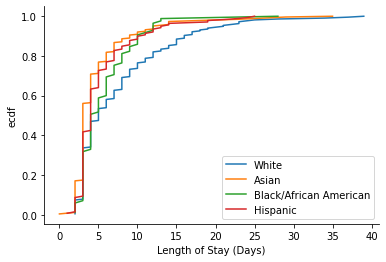

In [59]:
#Calculate the ECDF for each race, then plot. 

white_los = ecdf(merged_colorectal[merged_colorectal['Race'] == 'White']['Hospital Length of Stay'])
asian_los = ecdf(merged_colorectal[merged_colorectal['Race'] == 'Asian']['Hospital Length of Stay'])
black_los = ecdf(merged_colorectal[merged_colorectal['Race'] == 'Black or African American']['Hospital Length of Stay'])
hispanic_los = ecdf(merged_colorectal[merged_colorectal['Race'] == 'Hispanic']['Hospital Length of Stay'])

plt.plot(white_los[0],white_los[1], label = 'White')
plt.plot(asian_los[0],asian_los[1], label = 'Asian')
plt.plot(black_los[0],black_los[1], label = 'Black/African American')
plt.plot(hispanic_los[0],hispanic_los[1], label = 'Hispanic')
plt.legend()
sns.despine()
plt.xlabel('Length of Stay (Days)')
plt.ylabel('ecdf')
plt.show()

The most pronounced difference in LOS between racial groups is between whites and asians, with white patients staying
longer. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Hospital Length of Stay', ylabel='Density'>

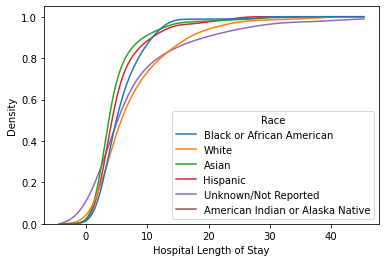

In [60]:
sns.kdeplot(
    data=merged_colorectal, x="Hospital Length of Stay", hue="Race",
    cumulative=True, common_norm=False, common_grid=True,
)

In [61]:
"""Is there a relationship between preferred language and length of stay?"""
merged_colorectal['Preferred Language'].value_counts(dropna = False)

en_US    722
NaN       40
es        24
zh         2
Name: Preferred Language, dtype: int64

There is not enough data to warrant a comparison

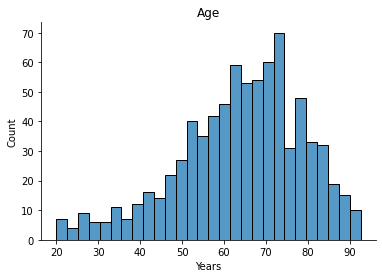

In [62]:
"""What is the makeup by age of the patient population?"""

sns.histplot(x = merged_colorectal['Age'], 
            bins = int(np.sqrt(merged_colorectal.shape[0])))
sns.despine()
plt.title('Age')
plt.xlabel('Years')

plt.show()


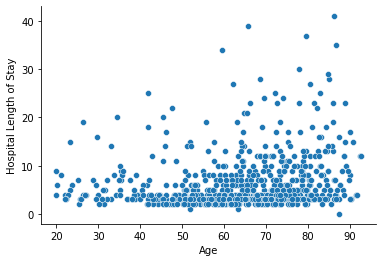

In [63]:
"""Is there a relationship between length of stay and age at time of surgery?"""

sns.scatterplot(x = merged_colorectal['Age'],
            y = merged_colorectal['Hospital Length of Stay'])
sns.despine()
plt.show()


In [64]:
""" Kendall's tau calculation to quantify correlation between age and LOS."""

ktau = merged_colorectal['Age'].corr(merged_colorectal['Hospital Length of Stay'],
                                     method = 'kendall')
print(f"Kendall's tau correlation coefficient = {ktau}")

Kendall's tau correlation coefficient = 0.1464539747259825


It appears as though age is weakly positively correlated with length of stay. 

In [65]:
"""Is there a difference in median age between the race groups? Age may serve as a confounding factor in this case,
and add an element of multicollinearity to our eventual regression model."""

merged_colorectal.groupby(by = 'Race')['Age'].agg([np.mean,np.std,np.size])

mean        std  size
Race                                                        
American Indian or Alaska Native  40.180000        NaN     1
Asian                             62.962576  14.729429   264
Black or African American         63.139294  13.335817    85
Hispanic                          62.151799  15.557610   139
Unknown/Not Reported              62.896615  14.963984    65
White                             67.067005  14.224730   217

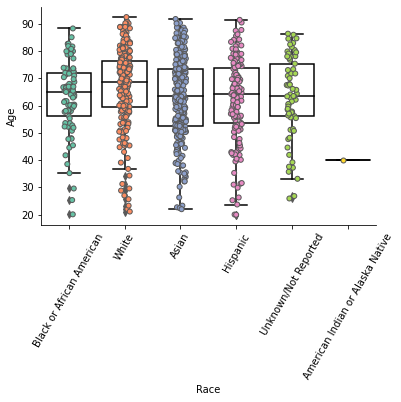

In [66]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Race', y = 'Age',data = merged_colorectal,color = 'white',**props, palette = 'Set2')
sns.stripplot(x = 'Race', y = 'Age',data = merged_colorectal, palette = 'Set2',linewidth = 1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

It appears as though white patients tend to be older than patients from other race groups, with a difference in median age of 4-5 years.

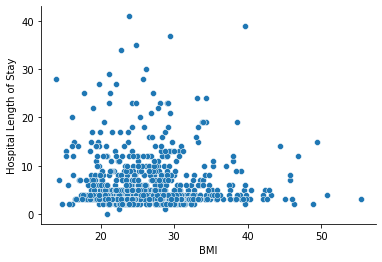

Kendall's tau correlation coefficient = -0.02346473786977141


In [67]:
"""Does body mass index, or BMI, correlate with length of stay? Increased BMI, especially at the level of obesity,
is associated with poorer health outcomes, generally, and has been linked to longer length of stay."""

sns.scatterplot(x = merged_colorectal['BMI'],
            y = merged_colorectal['Hospital Length of Stay'])
sns.despine()
plt.show()

ktau = merged_colorectal['BMI'].corr(merged_colorectal['Hospital Length of Stay'],
                                     method = 'kendall')

print(f"Kendall's tau correlation coefficient = {ktau}")

There is no obvious correlation between BMI and length of stay.

In [68]:
"""Does insurance payor status effect length of stay?"""

merged_colorectal['Primary Payor Status'].value_counts(dropna = False)

NaN                  262
Medicare             241
Medicaid             163
Private insurance    117
Other                  3
Self-pay               2
Name: Primary Payor Status, dtype: int64

There are 262 missing values, but let's see if there's anything interesting in the data

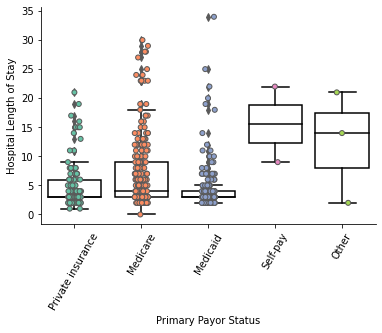

In [69]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = 'Primary Payor Status', 
            y = 'Hospital Length of Stay',
            data = merged_colorectal,color = 'white',
            **props, 
            palette = 'Set2')
sns.stripplot(x = 'Primary Payor Status', 
              y = 'Hospital Length of Stay',
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1)
plt.xticks(rotation = 60)
sns.despine()
plt.show()

There is no obvious difference in median length of stay between the various insurance classes for which sufficient data is present.

In [70]:
""" Comorbidities are severe medical conditions that negatively impact health and, potentially, length of stay.""" 

#Columns containing information related to co-morbidities.
comorb_cols = ['Ventilator Dependent',
 'History of Severe COPD',
 'Ascites', 
 'Heart Failure',
 'Sepsis',
 'Hypertension requiring medication',
 'Disseminated Cancer',
 'Immunosuppressive Therapy',
 'Malnourishment',
 'Bleeding Disorder',
 'Preop RBC Transfusions',
 'Preop COVID-19 Diagnosis', 
 'Diabetes Mellitus',
 'Current Smoker within 1 year',
 'Dyspnea']

# Display missing values
merged_colorectal[comorb_cols].isnull().sum()

Ventilator Dependent                   3
History of Severe COPD                 3
Ascites                                3
Heart Failure                          3
Sepsis                                 3
Hypertension requiring medication      3
Disseminated Cancer                    3
Immunosuppressive Therapy              3
Malnourishment                       188
Bleeding Disorder                      3
Preop RBC Transfusions                 3
Preop COVID-19 Diagnosis             526
Diabetes Mellitus                      3
Current Smoker within 1 year           3
Dyspnea                              188
dtype: int64

In [71]:
comorb_cols.remove('Preop COVID-19 Diagnosis')

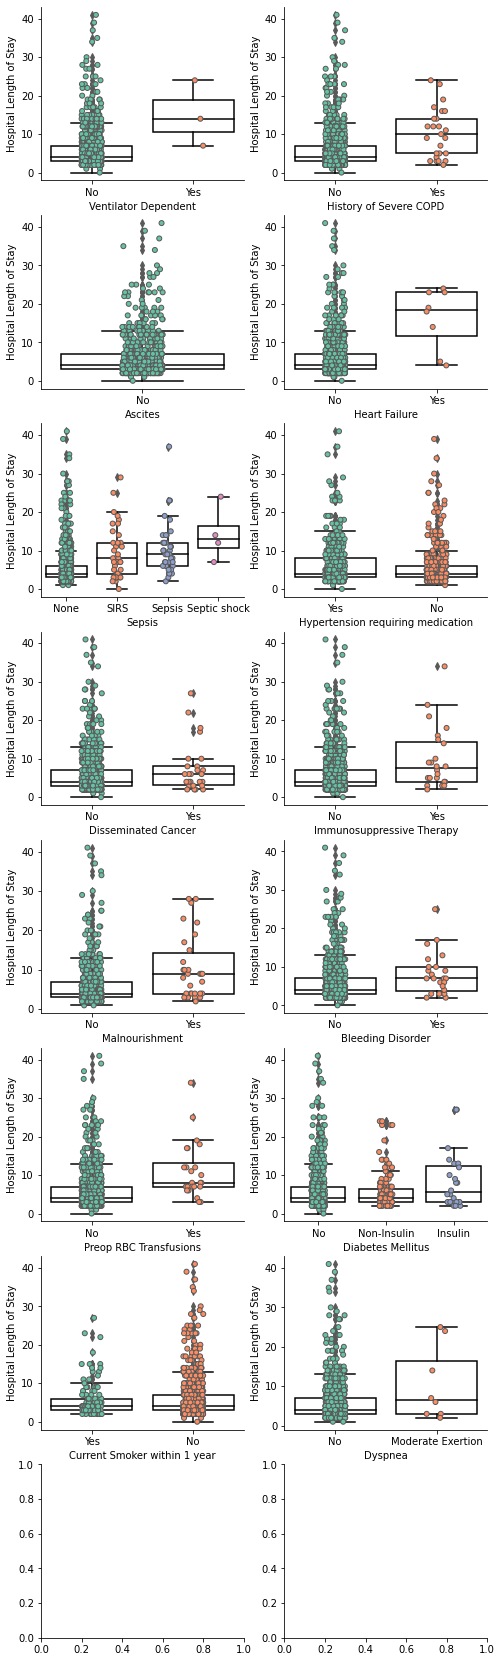

In [72]:
fig, axs = plt.subplots(nrows=8, ncols=2,figsize = (8,30))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(comorb_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

In [73]:
"""Because 'SIRS' and 'Sepsis' subcategories of the Sepsis variable have similar distributions, let's consolidate them 
in order to make a statistically robust comparison between presence and absence."""

merged_colorectal['Has Sepsis'] = np.where(merged_colorectal['Sepsis'] == 'None',
                                          'No',
                                          'Yes')

#Update list of comorbidity columns
comorb_cols.append('Has Sepsis')

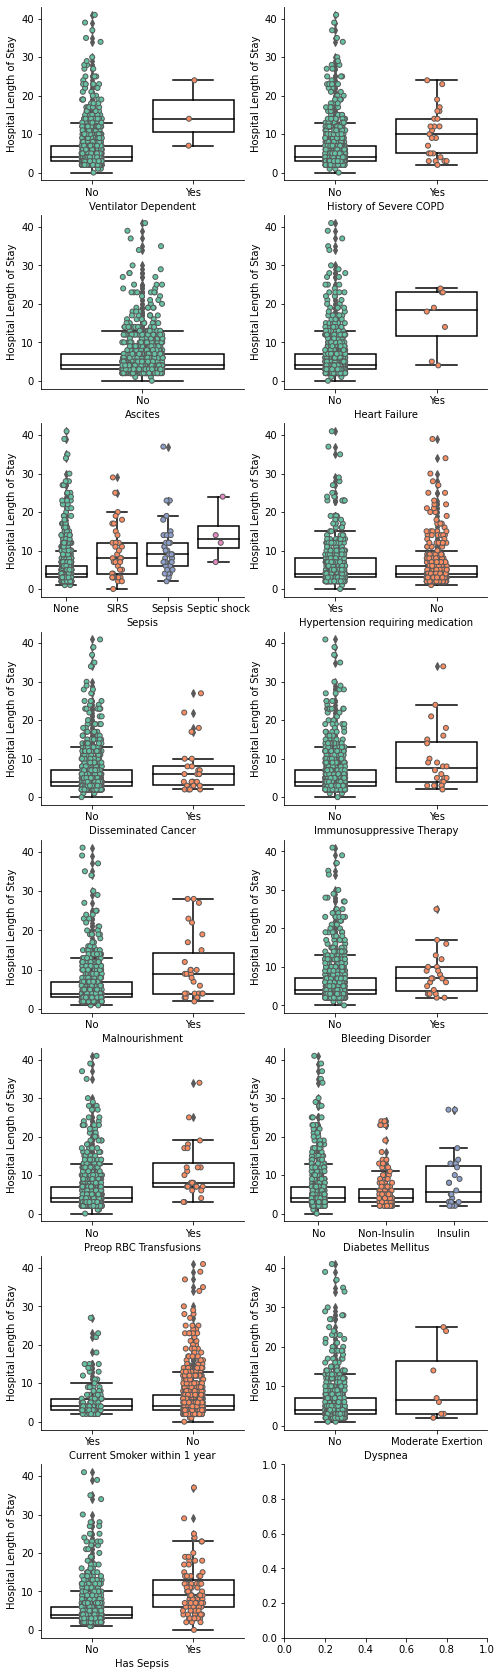

In [74]:
fig, axs = plt.subplots(nrows=8, ncols=2,figsize = (8,30))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(comorb_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

As with complications, the comorbidity categories are suffer from class imbalances. This is a problem because
it gives the model less information to learn from, and will leave comparisons underpowered. Including these variables
in the model could also lead to overfitting. 
To get around this, we will calculate the Charlson index for each patient. The Charlson index is a weighted sum of
comorbidities, and is commonly used in the medical community.

In [75]:
charlson_cols = ['Heart Failure',
                 'GS (>75) History of Dementia or Cognitive Impairment',
                 'History of Severe COPD',
                 'Diabetes Mellitus',
                 'Disseminated Cancer']

In [76]:
def Charlson(heart_failure, dementia, COPD, diabetes, cancer):
    score = 0
    if heart_failure == 'Yes':
        score += 1
    elif dementia == 'Yes':
        score += 1
    elif COPD == 'Yes':
        score += 1
    elif diabetes == 'Non-Insulin' or diabetes == 'Insulin':
        score += 1
    elif cancer == 'Yes':
        score += 6
    return score

In [77]:
merged_colorectal['Charlson'] = merged_colorectal.apply(lambda x: Charlson(x['Heart Failure'],
                                                                           x['GS (>75) History of Dementia or Cognitive Impairment'],
                                                                           x['History of Severe COPD'],
                                                                           x['Diabetes Mellitus'],
                                                                           x['Disseminated Cancer']), axis = 1)

In [78]:
merged_colorectal[['Heart Failure',
                 'GS (>75) History of Dementia or Cognitive Impairment',
                 'History of Severe COPD',
                 'Diabetes Mellitus',
                 'Disseminated Cancer',
                  'Charlson']]

Heart Failure GS (>75) History of Dementia or Cognitive Impairment  \
0              No                                                NaN     
1              No                                                NaN     
2              No                                                NaN     
3              No                                                NaN     
4              No                                                NaN     
5              No                                                NaN     
6              No                                                NaN     
7              No                                                NaN     
8              No                                                NaN     
9              No                                                NaN     
10             No                                                NaN     
11             No                                                NaN     
12             No                                                NaN     
13             No                                                NaN     
14             No                                                NaN     
15             No                                                NaN     
16             No                                                NaN     
17             No                                                NaN     
18             No                                                NaN     
19             No                                                NaN     
20             No                                                NaN     
21             No                                                NaN     
22             No                                                NaN     
23             No                                                NaN     
24             No                                                NaN     
25             No                                                NaN     
26             No                                                NaN     
27             No                                                NaN     
28             No                                                NaN     
29             No                                                NaN     
30             No                                                NaN     
31             No                                                NaN     
32             No                                                NaN     
33             No                                                NaN     
34             No                                                NaN     
35             No                                                NaN     
36             No                                                NaN     
37             No                                                NaN     
38             No                                                NaN     
39             No                                                NaN     
40             No                                                NaN     
41             No                                                NaN     
42             No                                                NaN     
43             No                                                NaN     
44             No                                                NaN     
45             No                                                NaN     
46             No                                                NaN     
47             No                                                NaN     
48             No                                                NaN     
49             No                                                NaN     
50             No                                                NaN     
51             No                                                NaN     
52             No                                                NaN     
53      

<AxesSubplot:xlabel='Charlson', ylabel='Hospital Length of Stay'>

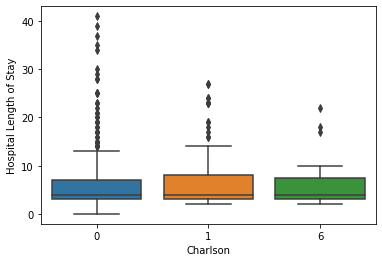

In [79]:
sns.boxplot(x = 'Charlson', y = 'Hospital Length of Stay', data = merged_colorectal)

Charlson score does not have an effect on long of stay in our dataset. We will not include it in our model.

In [80]:
"""Prior to surgery, blood is drawn to test critical markers of organ function and overall health. How do lab test 
values relate to length of stay?"""

# Columns containing lab test data
lab_tests = ['Serum Sodium', 'BUN','Serum Creatinine', 'Albumin', 'Total Bilirubin', 'AST/SGOT', 
             'Alkaline Phosphatase', 'WBC', 'Hematocrit', 'Hemoglobin A1c','Platelet Count', 'INR', 'PTT']


In [81]:
merged_colorectal[lab_tests].dtypes

Serum Sodium            float64
BUN                     float64
Serum Creatinine        float64
Albumin                 float64
Total Bilirubin         float64
AST/SGOT                float64
Alkaline Phosphatase    float64
WBC                     float64
Hematocrit              float64
Hemoglobin A1c          float64
Platelet Count          float64
INR                     float64
PTT                     float64
dtype: object

In [82]:
# Check for missing values
merged_colorectal[lab_tests].isnull().sum()

Serum Sodium             14
BUN                      16
Serum Creatinine         14
Albumin                  47
Total Bilirubin          48
AST/SGOT                 52
Alkaline Phosphatase     51
WBC                      12
Hematocrit               10
Hemoglobin A1c          732
Platelet Count           10
INR                      46
PTT                     129
dtype: int64

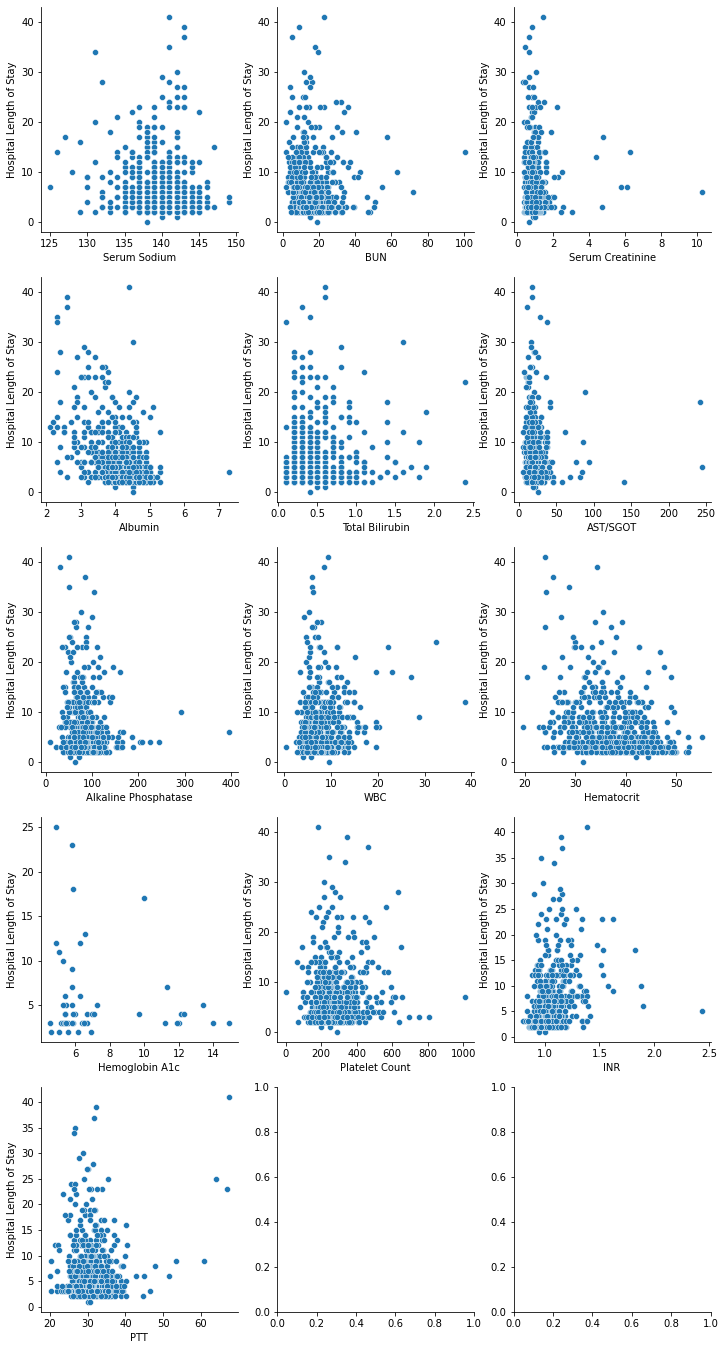

In [83]:

fig, axs = plt.subplots(nrows=5, ncols=3,figsize = (12,24))

for col, ax in zip(lab_tests, axs.ravel()):
    sns.scatterplot(x = col, y = 'Hospital Length of Stay', data = merged_colorectal,ax = ax)
    sns.despine()

In [84]:
"""Determine the correlation coefficients between each lab test value and length of stay."""

merged_colorectal[lab_tests].corrwith(merged_colorectal['Hospital Length of Stay'],
                                     method = 'kendall')

Serum Sodium           -0.128454
BUN                    -0.112422
Serum Creatinine       -0.026203
Albumin                -0.294010
Total Bilirubin         0.005937
AST/SGOT               -0.088802
Alkaline Phosphatase    0.010084
WBC                     0.131217
Hematocrit             -0.241360
Hemoglobin A1c          0.000000
Platelet Count          0.073914
INR                     0.268272
PTT                    -0.015363
dtype: float64

Conventionally, values close to and above +-0.3 are evidence of correlation. Accordingly, albumin, hematocrit, and INR
are likely predictors of length of stay. 

    Albumin is a marker of overall health, and higher levels have been linked to shorter length of stay following surgery.

    Hematocrit is the percentage by volume of blood cells, and effects oxygenation of the tissues. 

    INR, or international normalized ratio, indicates how long it takes for blood to clot. The higher the value, the longer the clotting time. 

Given what these three values indicate, their correlation with length of stay makes sense.

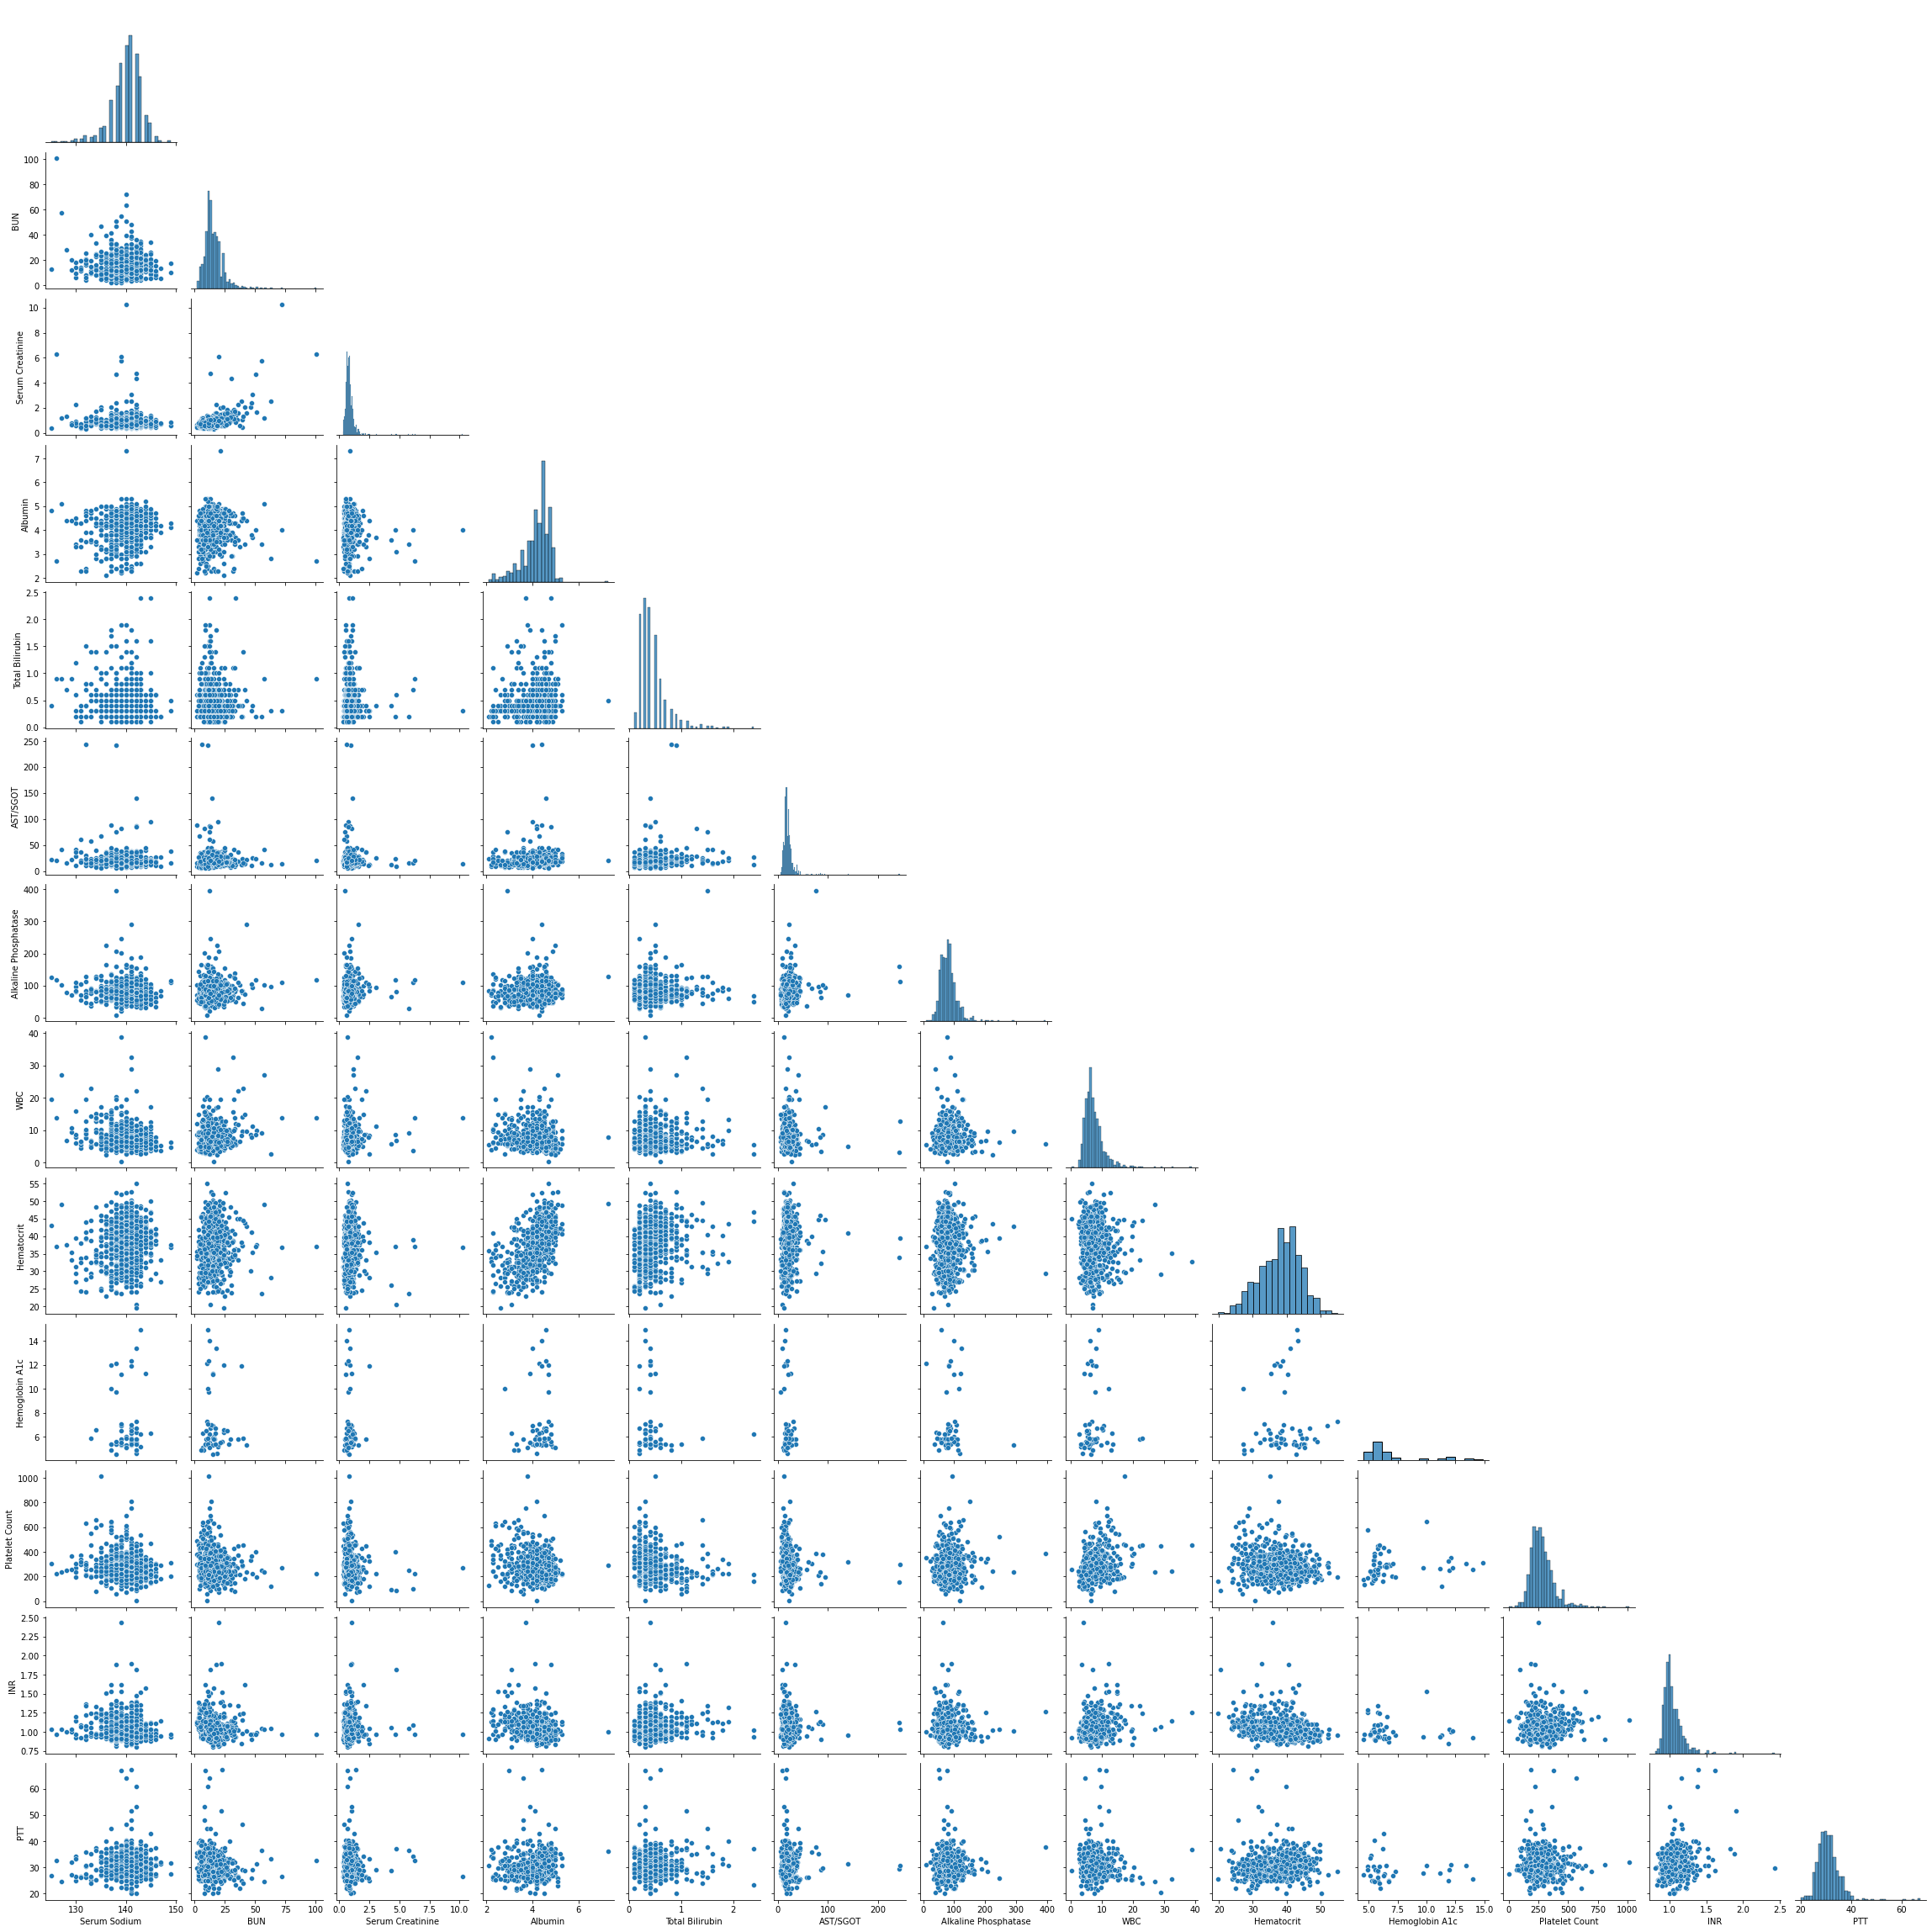

In [85]:
sns.pairplot(data = merged_colorectal[lab_tests],corner = True)


<AxesSubplot:>

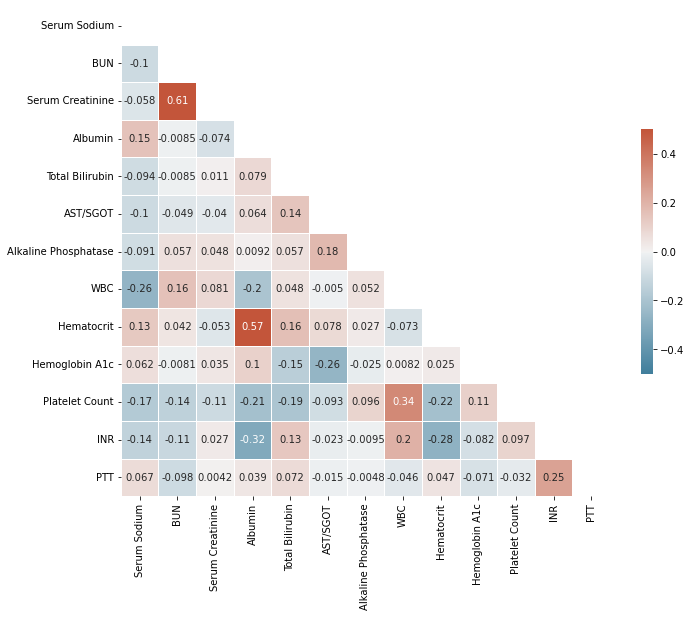

In [114]:
lab_test_corrs = merged_colorectal[lab_tests].corr()

#create a mask to zero out cells that evaluate to 1, or True
mask = np.triu(np.ones_like(lab_test_corrs, dtype = bool))

#create a colormap, blue for negative correlations, red for positive
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, axes = plt.subplots(figsize = (11,9))
sns.heatmap(lab_test_corrs,
            mask = mask, 
            vmax = 0.5,
            vmin = -0.5,
            center = 0, 
            square = True, 
            linewidths = 0.5, 
            cmap = cmap,
            annot = True,
            cbar_kws = {'shrink':0.5})

In [86]:
"""Complications that arise as a result of surgery are an important factor in determining length of stay. The 
following columns relate to complications."""

complications_cols = ['Num of Postop Superficial Incisional SSI',
                     'Num of Postop Deep Incisional SSI',
                     'Num of Postop Organ/Space SSI',
                     'Num of Postop Wound Disruption', 
                     'Num of Postop Pneumonia',
                     'Num of Postop Unplanned Intubation',
                     'Num of Postop Pulmonary Embolism',
                     'Num of Postop On Ventilator > 48 hours',
                     'Num of Stroke/Cerebral Vascular Acccident (CVA)',
                     'Num of Cardiac Arrest Requiring CPR', 
                     'Num of Myocardial Infarction',
                     'Num of Postop Blood Transfusions (72h of surgery start time)',
                     'Total Blood Transfused (in units)', 
                     'Num of Postop C. diff',
                     'Num of Postop Sepsis',
                     'Num of Postop Septic Shock',
                     'Num of Postop Other Occurrences', 
                     'New Postop COVID-19 Diagnosis',
                     'Still in Hospital >30 Days',
                     'Postop Death w/in 30 days of Procedure',
                     'Num of Readmissions w/in 30 days',
                     'Num of Unplanned Readmissions',
                     'Num of Readmissions likely related to principal procedure',
                     'Num of Readmissions likely unrelated to principal procedure',
                     'Num of First Unplanned Return Procedures',
                     'Num of Second Unplanned Return Procedures']

# Remove columns which leak information, or do not relate to the original procedure.

complications_cols = ['Num of Postop Superficial Incisional SSI',
                     'Num of Postop Deep Incisional SSI',
                     'Num of Postop Organ/Space SSI',
                     'Num of Postop Wound Disruption', 
                     'Num of Postop Pneumonia',
                     'Num of Postop Unplanned Intubation',
                     'Num of Postop Pulmonary Embolism',
                     'Num of Postop On Ventilator > 48 hours',
                     'Num of Stroke/Cerebral Vascular Acccident (CVA)',
                     'Num of Cardiac Arrest Requiring CPR', 
                     'Num of Myocardial Infarction',
                     'Num of Postop Blood Transfusions',
                     'Total Blood Transfused (in units)', 
                     'Num of Postop C. diff',
                     'Num of Postop Sepsis',
                     'Num of Postop Septic Shock',
                     'Num of Postop Other Occurrences', 
                     'New Postop COVID-19 Diagnosis',
                     #'Still in Hospital >30 Days',
                     #'Postop Death w/in 30 days of Procedure',
                     #'Num of Readmissions w/in 30 days',
                     #'Num of Unplanned Readmissions',
                     #'Num of Readmissions likely related to principal procedure',
                     #'Num of Readmissions likely unrelated to principal procedure',
                     #'Num of First Unplanned Return Procedures',
                     #'Num of Second Unplanned Return Procedures'
                     ]

In [87]:
merged_colorectal[complications_cols].isnull().sum()

Num of Postop Superficial Incisional SSI             0
Num of Postop Deep Incisional SSI                    0
Num of Postop Organ/Space SSI                        0
Num of Postop Wound Disruption                       0
Num of Postop Pneumonia                              0
Num of Postop Unplanned Intubation                   0
Num of Postop Pulmonary Embolism                     0
Num of Postop On Ventilator > 48 hours               0
Num of Stroke/Cerebral Vascular Acccident (CVA)      0
Num of Cardiac Arrest Requiring CPR                  0
Num of Myocardial Infarction                         0
Num of Postop Blood Transfusions                     0
Total Blood Transfused (in units)                  728
Num of Postop C. diff                                0
Num of Postop Sepsis                                 0
Num of Postop Septic Shock                           0
Num of Postop Other Occurrences                      0
New Postop COVID-19 Diagnosis                      563
dtype: int

In [132]:
# Let's drop 'Total Blood Transfused (in units)' and 'New Postop COVID-19 Diagnosis' from the complications list

complications_cols = [col for col in complications_cols if col not in ['Total Blood Transfused (in units)','New Postop COVID-19 Diagnosis']]


In [133]:
complications_cols

['Num of Postop Superficial Incisional SSI',
 'Num of Postop Deep Incisional SSI',
 'Num of Postop Organ/Space SSI',
 'Num of Postop Wound Disruption',
 'Num of Postop Pneumonia',
 'Num of Postop Unplanned Intubation',
 'Num of Postop Pulmonary Embolism',
 'Num of Postop On Ventilator > 48 hours',
 'Num of Stroke/Cerebral Vascular Acccident (CVA)',
 'Num of Cardiac Arrest Requiring CPR',
 'Num of Myocardial Infarction',
 'Num of Postop Blood Transfusions',
 'Num of Postop C. diff',
 'Num of Postop Sepsis',
 'Num of Postop Septic Shock',
 'Num of Postop Other Occurrences',
 'Num of Postop Venous Thrombosis Requiring Therapy']

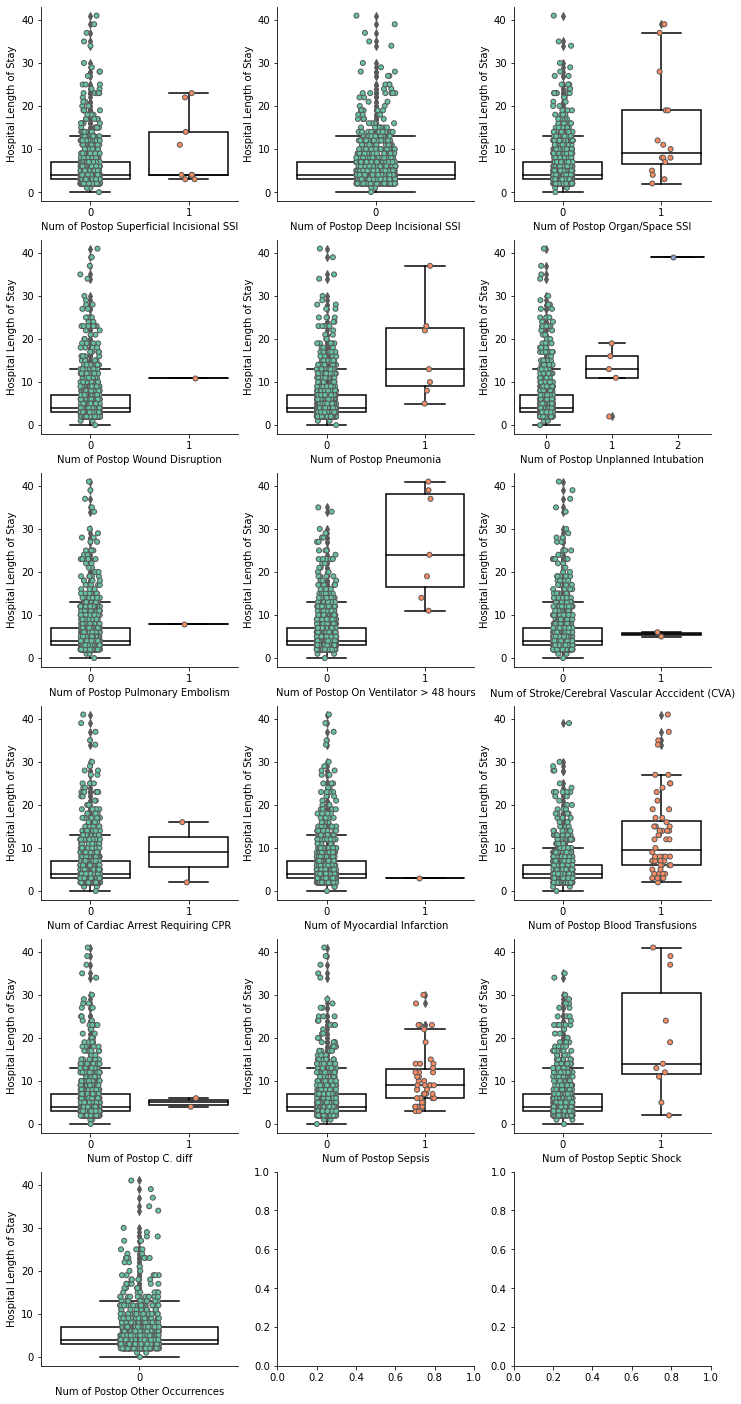

In [89]:
#Plot complications vs length of stay

fig, axs = plt.subplots(nrows=6, ncols=3,figsize = (12,25))
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
for col, ax in zip(complications_cols, axs.ravel()):
    sns.stripplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  linewidth = 1,
                  jitter = 0.1,
                  palette = 'Set2')
    sns.boxplot(x = col, y = 'Hospital Length of Stay', 
                  data = merged_colorectal,
                  ax = ax,
                  palette = 'Set2',
                  **props)
    sns.despine()

In [134]:
"""Owing to the large class imbalance for most complications columns, we will sum complications and look at the
aggregate effect on length of stay. This can be justified by the fact that in all cases, based on the boxplots above,
having a complication increases length of stay."""

merged_colorectal['Summed Complications'] = merged_colorectal[complications_cols].sum(axis = 1)

merged_colorectal['Summed Complications'].value_counts().sort_index()

0    663
1     98
2     14
3      7
4      2
5      3
6      1
Name: Summed Complications, dtype: int64

In [135]:
"""Bin complications into new ordinal column to look at aggregate effect of complications on length of stay."""

def bin_complications(num_complications):
    if num_complications == 0:
        Binned_complications = 'None'
    elif num_complications == 1:
        Binned_complications = 'One'
    elif num_complications == 2:
        Binned_complications = 'Two'
    elif num_complications >= 3:
        Binned_complications = 'Three_or_more'
    
    return Binned_complications


merged_colorectal['Binned Complications'] = merged_colorectal['Summed Complications'].apply(bin_complications)

In [136]:
merged_colorectal['Binned Complications']

0      Three_or_more
1                Two
2               None
3               None
4               None
5                One
6               None
7                One
8               None
9               None
10              None
11              None
12              None
13              None
14              None
15              None
16              None
17               Two
18              None
19              None
20               One
21              None
22              None
23              None
24              None
25              None
26               Two
27               One
28              None
29              None
30              None
31              None
32              None
33              None
34              None
35               One
36              None
37              None
38              None
39              None
40              None
41              None
42              None
43              None
44              None
45              None
46              None
47           

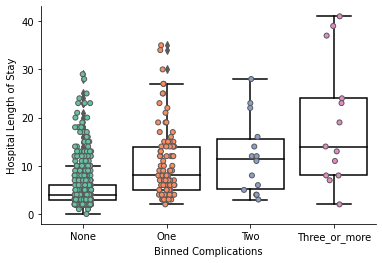

In [137]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = merged_colorectal['Binned Complications'], 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal, 
            color = 'white',
            **props, palette = 'Set2',
            order = ['None','One','Two','Three_or_more'])
sns.stripplot(x = merged_colorectal['Binned Complications'], 
            y = 'Hospital Length of Stay',
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = ['None','One','Two','Three_or_more'])
#plt.xticks(rotation = 60)
sns.despine()
plt.show()



Length of stay increases monotonically with the number of complications. We will therefore include the 'binned_complications' variable in our model.

In [138]:
"""Let's assess the extent of missing data in the columns of interest."""

model_cols = ['Age',
              'Race',
              'Open or Laparoscopic',
              'BMI',
              'Case Acuity',
              'Functionally Indpdnt or Dpdnt',
              'Duration of Surgical Procedure (in minutes)']
model_cols.extend(lab_tests)
model_cols.extend(comorb_cols)
model_cols.extend(complications_cols)


In [139]:
model_cols

['Age',
 'Race',
 'Open or Laparoscopic',
 'BMI',
 'Case Acuity',
 'Functionally Indpdnt or Dpdnt',
 'Duration of Surgical Procedure (in minutes)',
 'Serum Sodium',
 'BUN',
 'Serum Creatinine',
 'Albumin',
 'Total Bilirubin',
 'AST/SGOT',
 'Alkaline Phosphatase',
 'WBC',
 'Hematocrit',
 'Hemoglobin A1c',
 'Platelet Count',
 'INR',
 'PTT',
 'Ventilator Dependent',
 'History of Severe COPD',
 'Ascites',
 'Heart Failure',
 'Sepsis',
 'Hypertension requiring medication',
 'Disseminated Cancer',
 'Immunosuppressive Therapy',
 'Malnourishment',
 'Bleeding Disorder',
 'Preop RBC Transfusions',
 'Diabetes Mellitus',
 'Current Smoker within 1 year',
 'Dyspnea',
 'Has Sepsis',
 'Num of Postop Superficial Incisional SSI',
 'Num of Postop Deep Incisional SSI',
 'Num of Postop Organ/Space SSI',
 'Num of Postop Wound Disruption',
 'Num of Postop Pneumonia',
 'Num of Postop Unplanned Intubation',
 'Num of Postop Pulmonary Embolism',
 'Num of Postop On Ventilator > 48 hours',
 'Num of Stroke/Cerebral 

<AxesSubplot:>

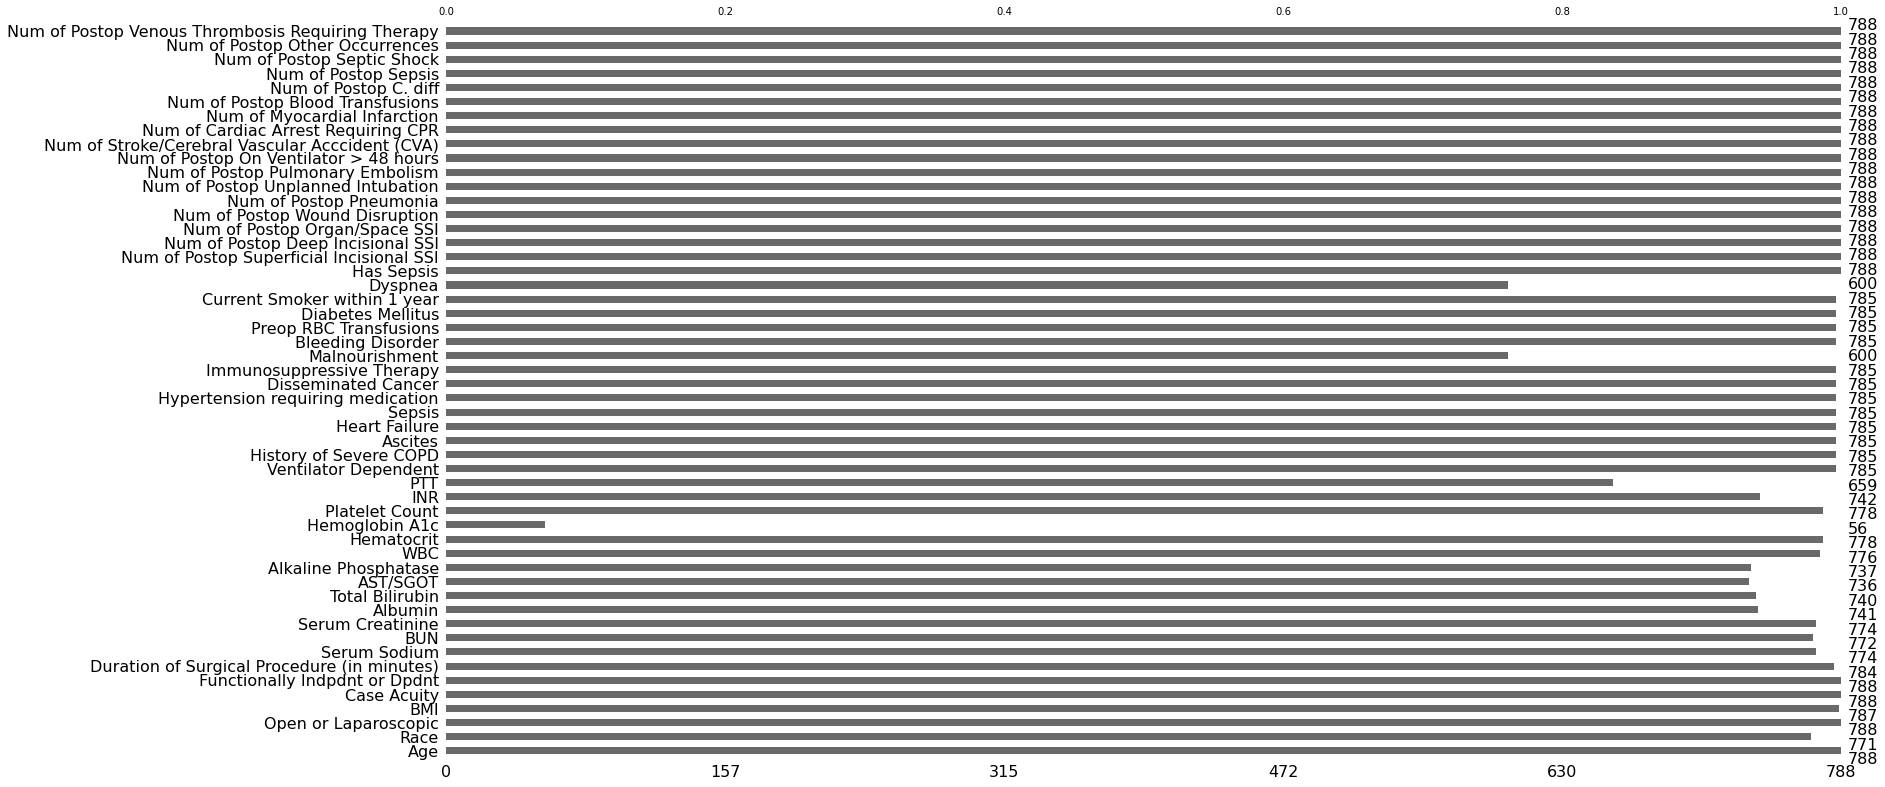

In [140]:
# Bar plot to display the amount of missing data in each column
msno.bar(merged_colorectal[model_cols])

The following columns are missing the vast majority of their data and may reduce the accuracy of the imputation:

'Hemoglobin A1c', 
'Total Blood Transfused', 
'New Postop COVID-19 Diagnosis',
'Preop COVID-19 Diagnosis'

<AxesSubplot:>

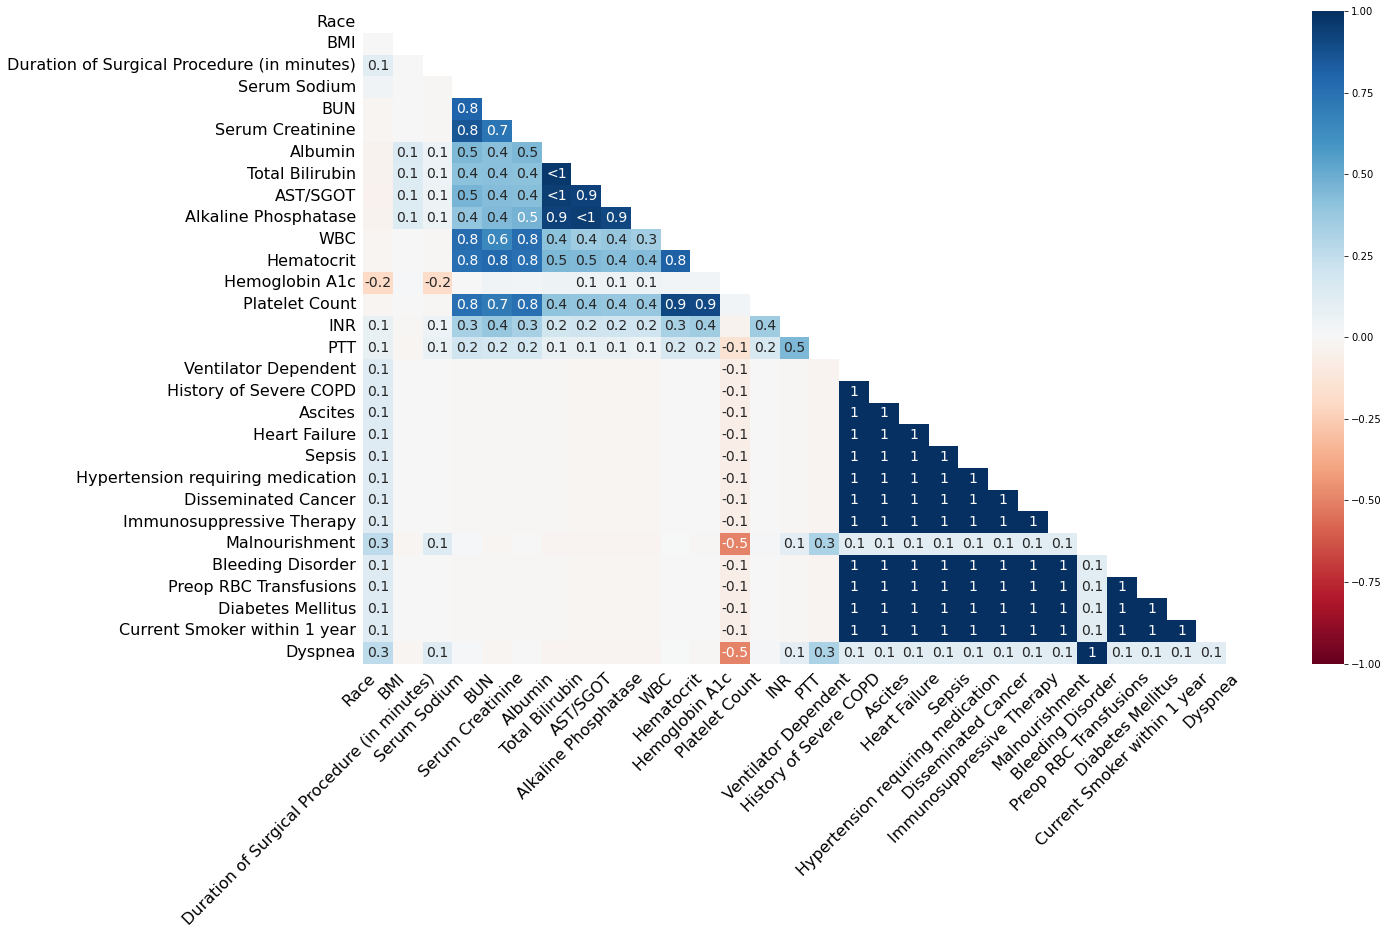

In [141]:
"""Heatmap to display pairwise correlations of present/missing data:
     1 indicates missing data in one column perfectly predicts the missing data in the other column of the pair
    -1 indicates missing data in one column does not at all predict the missing data in the other column of the pair"""

msno.heatmap(merged_colorectal[model_cols])

Where high positive correlations exist they are between missing lab values and missing comorbidity/complications values, and not between such values and demographic information,i.e race and age. This indicates that there is a group of patients for whom the record is simply incomplete, and not that there is some bias in the data collection process. We will therefore assume data is missing at random, and proceed to imputation.

We will model the data first without imputation, simply dropping rows with missing values, and then proceed to modeling the imputed dataset. This approach will help us determine the validity of the imputation approach.

In [142]:
%%capture

"""Now that data cleaning and EDA are complete, it is time to develop a predictive model of length of stay. One 
approach is to build a generalized linear model for count data, which basically extends the logic of least squares
regression to non-normally distributed data. Typically Poisson and negative binomial regression are utilized for 
modeling count data. The key difference between these methods is that Poisson regression assumes that the distribution 
being modeled has variance equal to the mean, whereas negative binomial regression has no such assumption. Negative 
binomial regression allows for variance to vary as a quadratic function of the mean. """

In [143]:
df_for_model = merged_colorectal[['Age',
                                 'Albumin',
                                 'INR',
                                 'Hematocrit',
                                 'Binned Complications',                                  
                                 'Race',
                                 'Platelet Count',
                                 'BUN',
                                 'Open or Laparoscopic',
                                 'Functionally Indpdnt or Dpdnt',
                                 'Hospital Length of Stay',
                                 'Has Sepsis',
                                 'Immunosuppressive Therapy',
                                 'Preop RBC Transfusions',
                                 'Heart Failure',
                                 'Hypertension requiring medication',
                                 'Disseminated Cancer',
                                 'Bleeding Disorder',
                                 'Diabetes Mellitus',
                                 'Current Smoker within 1 year',
                                 'Ventilator Dependent',
                                 'Charlson',
                                 'History of Severe COPD',
                                 'Operation dow']]


In [144]:
## Drop null values
df_for_model = df_for_model.dropna(subset = ['Age',
                                 'Albumin',
                                 'INR',
                                 'Hematocrit',
                                 'Binned Complications',                                  
                                 'Race',
                                 'Platelet Count',
                                 'BUN',
                                 'Open or Laparoscopic',
                                 'Functionally Indpdnt or Dpdnt',
                                 'Hospital Length of Stay',
                                 'Has Sepsis',
                                 'Immunosuppressive Therapy',
                                 'Preop RBC Transfusions',
                                 'Heart Failure',
                                 'Hypertension requiring medication',
                                 'Disseminated Cancer',
                                 'Bleeding Disorder',
                                 'Diabetes Mellitus',
                                 'Current Smoker within 1 year',
                                 'Ventilator Dependent',
                                 'Charlson',
                                            'History of Severe COPD',
                                            'Operation dow'])

In [145]:
#Format column names for Patsy
df_for_model.columns = df_for_model.columns.str.replace(' ', '_')

In [146]:
%%capture

"""Let's define a formula for the statsmodels GLM package. We will use the Patsy package to define a design matrix."""

# formula, in statsmodels format, using Patsy 
expr = """ Hospital_Length_of_Stay ~ Albumin + INR  + Hematocrit + C(Race, Treatment(1)) + C(Binned_Complications) +
C(Open_or_Laparoscopic) + C(Functionally_Indpdnt_or_Dpdnt) + Age + C(Heart_Failure) + C(Has_Sepsis) + 
C(History_of_Severe_COPD) """

In [147]:
# Fit and print the results of a glm model with the above model matrix configuration. We will first fit a Poisson
# regression model.

Poisson_reg = glm(expr,
            data = df_for_model, 
            family = sm.families.Poisson()).fit()

print(Poisson_reg.summary2())

                                    Results: Generalized linear model
Model:                           GLM                                AIC:                       3720.6266 
Link Function:                   log                                BIC:                       -3065.5654
Dependent Variable:              Hospital_Length_of_Stay            Log-Likelihood:            -1842.3   
Date:                            2022-08-25 22:18                   LL-Null:                   -2439.0   
No. Observations:                688                                Deviance:                  1312.1    
Df Model:                        17                                 Pearson chi2:              1.56e+03  
Df Residuals:                    670                                Scale:                     1.0000    
Method:                          IRLS                                                                    
----------------------------------------------------------------------------------

In [148]:
# Fit and print the results of a glm model with the above model matrix configuration

NB2_reg = glm(expr,  
            data = df_for_model,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 1.57, the median of the bootstrapped distribution
            family = sm.families.NegativeBinomial(alpha = 0.3636)).fit()

print(NB2_reg.summary2())

                                    Results: Generalized linear model
Model:                           GLM                                AIC:                       3510.4991 
Link Function:                   log                                BIC:                       -4028.8285
Dependent Variable:              Hospital_Length_of_Stay            Log-Likelihood:            -1737.2   
Date:                            2022-08-25 22:18                   LL-Null:                   -1902.8   
No. Observations:                688                                Deviance:                  348.81    
Df Model:                        17                                 Pearson chi2:              448.      
Df Residuals:                    670                                Scale:                     1.0000    
Method:                          IRLS                                                                    
----------------------------------------------------------------------------------

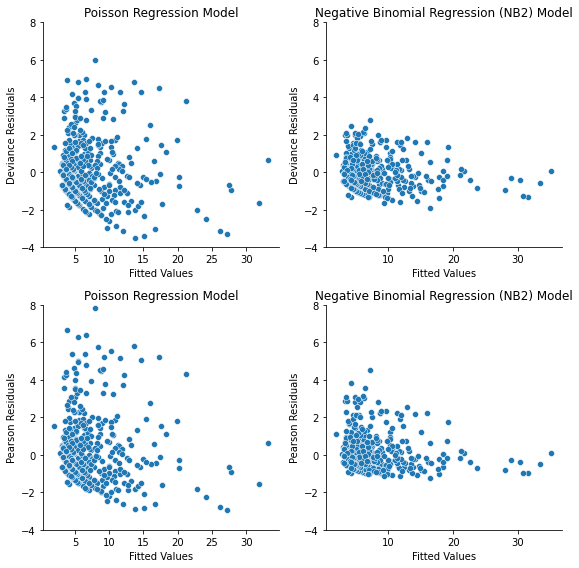

In [149]:
"""Diagnostic plots. 
To compare the performance and suitability of the Poisson and negative binomial regression for modeling length of 
stay, let's look at two metrics:

1) Deviance is the difference in log likelihoods between the proposed and saturated models, and indicates
how good of a fit the proposed model is to the data. Plotting deviance residuals as a function of fitted values 
therefore reveals the contribution of each fitted value to the model deviance. 

2) A Pearson residual is the difference between predicted and observed value, standardized by the standard deviation
of the observed value. The presence of a large number of values beyond +-2 standard deviations therefore suggests
poor model fit."""


fig,axes = plt.subplots(2,2,figsize = (8,8))
sns.scatterplot(x = Poisson_reg.fittedvalues,y = Poisson_reg.resid_deviance,ax = axes[0][0])
axes[0][0].set_xlabel('Fitted Values')
axes[0][0].set_ylabel('Deviance Residuals')
axes[0][0].set_title('Poisson Regression Model')
axes[0][0].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = NB2_reg.fittedvalues,y = NB2_reg.resid_deviance, ax = axes[0][1])
axes[0][1].set_xlabel('Fitted Values')
axes[0][1].set_ylabel('Deviance Residuals')
axes[0][1].set_title('Negative Binomial Regression (NB2) Model')
axes[0][1].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = Poisson_reg.fittedvalues,y = Poisson_reg.resid_pearson,ax = axes[1][0])
axes[1][0].set_xlabel('Fitted Values')
axes[1][0].set_ylabel('Pearson Residuals')
axes[1][0].set_title('Poisson Regression Model')
axes[1][0].set_ylim(bottom = -4, top = 8)
sns.scatterplot(x = NB2_reg.fittedvalues,y = NB2_reg.resid_pearson, ax = axes[1][1])
axes[1][1].set_xlabel('Fitted Values')
axes[1][1].set_ylabel('Pearson Residuals')
axes[1][1].set_title('Negative Binomial Regression (NB2) Model')
axes[1][1].set_ylim(bottom = -4, top = 8)

sns.despine()

fig.tight_layout()

plt.show()

The negative binomial regression model leads to smaller deviance and Pearson residuals than the Poisson regression model. 

In [150]:
"""Perform a chi-square test comparing the the NB2 model with a dispersion parameter, and the Poisson model with mean
equal to the variance. The null hypothesis is that the value of the dispersion parameter should be 1, in other words,
that the negative binomial regression is not a better fit than Poisson regression."""

def likelihood_ratio_test(log_likelihood_null, log_likelihood_alt, df):

    LR_statistic = -2 * (log_likelihood_null - log_likelihood_alt)

    p_val = scipy.stats.chi2.sf(LR_statistic, df)

    print(f"p-value = {p_val}")
    return(LR_statistic, p_val)

In [151]:
likelihood_ratio_test(Poisson_reg.llf, NB2_reg.llf, df = 1)

p-value = 1.2884006297599814e-47


(210.12749097335063, 1.2884006297599814e-47)

Given the p-value, we should reject the null hypothesis that negative binomial regression, with its additonal dispersion parameter, does not provide a better fit to the data than does Poisson regression.


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


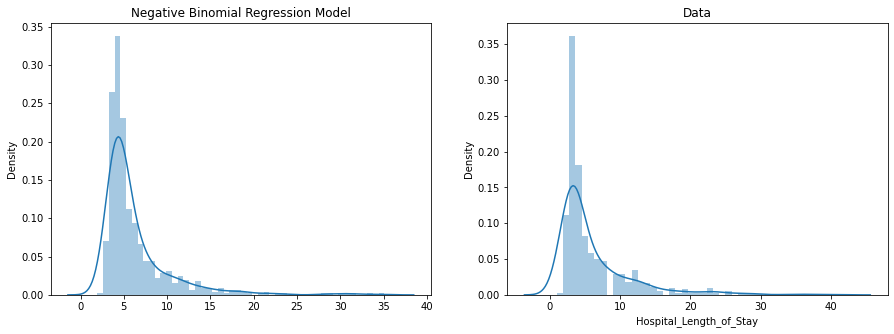

In [152]:
# plot distributions
fig, axes = plt.subplots(1,2, 
                         squeeze = False, 
                         figsize = (15,5))
sns.distplot(NB2_reg.predict(), ax = axes[0][0])
axes[0][0].set_title('Negative Binomial Regression Model')
sns.distplot(df_for_model['Hospital_Length_of_Stay'], ax = axes[0][1])
axes[0][1].set_title('Data')

plt.show()


The negative binomial regression models appears to recapitulate the main features of the data, but underestimates
the probability density of the tail.

In [153]:
"""We will now develop and validate a negative binomial regression model. To validate the model, we will use K-fold
cross-validation to assess our model's ability to predict length of stay given unseen data."""

# Root mean squared error is a common metric for evaluating model performance. It is defined as the square root of the
# mean squared error, with the error being the difference between acual and predicted values. Let's define a function
# to calculate RMSE.

def RMSE(pred, actual):
    """Calculate RMSE """
    squared_error = np.sum(((array1 - array2) **2))
    RMSE = np.sqrt(squared_error / len(array1))
    return RMSE

In [ ]:
def RMSLE(pred, actual):
    """Calculate root-mean-squared logarithmic error for test fold"""
rmsle = np.sqrt(np.mean(np.square(np.log1p(pred) - np.log1p(actual))))

In [154]:
# Reset the index

df_for_model = df_for_model.reset_index()

In [155]:
"""Let's perform k-fold cross-validation on both the Poisson and negative binomial regression models. This will allow
us to directly assess the accuracy of each model when making predictions of length of stay based on unseen data."""


# Creating kfold column and intiate it with a dummy value
df_for_model["kfold"] = -1

# for loop to create the k-folds
kf = KFold(n_splits = 10, shuffle = True)
for fold, (train_indicies, test_indicies) in enumerate(kf.split(X = df_for_model)):
    df_for_model.loc[test_indicies, "kfold"] = fold

NB2_summaries = {}
NB2_test_predictions = []
NB2_training_predictions = []
NB2_test_RMSEs = []
NB2_train_RMSEs = []

Poisson_summaries = {}
Poisson_test_predictions = []
Poisson_training_predictions = []
Poisson_test_RMSEs = []
Poisson_train_RMSEs = []

for i in range(10):
    y_train, x_train = dmatrices(expr, 
                                df_for_model[df_for_model['kfold'] != i],
                                return_type = 'dataframe')
    y_test, x_test = dmatrices(expr, 
                               df_for_model[df_for_model['kfold'] == i], 
                               return_type = 'dataframe')
        
    x_train, x_test = x_train.align(x_test, join = 'outer', axis = 1, fill_value = 0)
    
    # Fit negative binomial regression model
    NB2_model = sm.GLM(y_train, 
                       x_train, 
                       family = sm.families.NegativeBinomial(alpha = 0.3636)).fit() 
    NB2_summaries[i] = NB2_model.summary2()
    
    #Generate predictions on test set
    NB2_test_predicted = NB2_model.get_prediction(x_test)
    NB2_test_predictions.append(NB2_test_predicted)
    
    #Generate predictions on train set
    NB2_training_predicted = NB2_model.get_prediction(x_train)
    NB2_training_predictions.append(NB2_training_predicted)
    
    #Calculate RMSE for test fold
    NB2_test_RMSE = RMSE(NB2_test_predicted.summary_frame()['mean'],
                         y_test['Hospital_Length_of_Stay'])
    NB2_test_RMSEs.append(NB2_test_RMSE)    

    #Calculate RMSE for training folds
    NB2_train_RMSE = RMSE(NB2_training_predicted.summary_frame()['mean'],
                          y_train['Hospital_Length_of_Stay'])
    NB2_train_RMSEs.append(NB2_train_RMSE)

    
    
    # Fit Poisson regression model
    Poisson_model = sm.GLM(y_train, 
                           x_train, 
                           family = sm.families.Poisson()).fit()
     
    Poisson_summaries[i] = Poisson_model.summary2()
    
    #Generate predictions on test folds
    Poisson_test_predicted = Poisson_model.get_prediction(x_test)
    Poisson_test_predictions.append(Poisson_test_predicted)
   
    #Generate predictions on train folds
    Poisson_training_predicted = Poisson_model.get_prediction(x_train)
    Poisson_training_predictions.append(Poisson_training_predicted)
    
    #Calculate RMSE for test fold
    Poisson_test_RMSE = RMSE(Poisson_test_predicted.summary_frame()['mean'],
                             y_test['Hospital_Length_of_Stay'])
    Poisson_test_RMSEs.append(Poisson_test_RMSE)    
    
    #Calculate RMSE for training folds
    Poisson_train_RMSE = RMSE(Poisson_training_predicted.summary_frame()['mean'],
                              y_train['Hospital_Length_of_Stay'])
    Poisson_train_RMSEs.append(Poisson_train_RMSE)



In [156]:
"""Calculate the mean test and training RMSEs for both models"""

#Negative binomial regression model 
NB2_mean_test_RMSE = (np.sum(NB2_test_RMSEs) / len(NB2_test_RMSEs))
NB2_mean_train_RMSE = (np.sum(NB2_train_RMSEs)/len(NB2_train_RMSEs))

print(f" The average RMSE for NB2 model predictions on test folds = {NB2_mean_test_RMSE}")
print(f" The average RMSE for NB2 model predictions on training folds  = {NB2_mean_train_RMSE}")


#Poisson regression model
Poisson_mean_test_RMSE = (np.sum(Poisson_test_RMSEs) / len(Poisson_test_RMSEs))
Poisson_mean_train_RMSE = (np.sum(Poisson_train_RMSEs)/len(Poisson_train_RMSEs))

print(f" The average RMSE for Poisson model predictions on test folds = {Poisson_mean_test_RMSE}")
print(f" The average RMSE for Poisson model predictions on training folds  = {Poisson_mean_train_RMSE}")

 The average RMSE for NB2 model predictions on test folds = 4.587996389326941
 The average RMSE for NB2 model predictions on training folds  = 4.377109816375557
 The average RMSE for Poisson model predictions on test folds = 4.538750895148935
 The average RMSE for Poisson model predictions on training folds  = 4.239814131643433


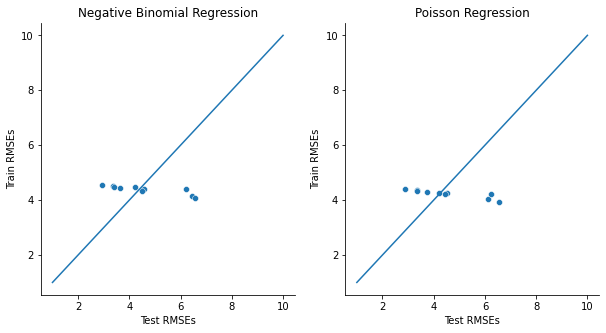

In [157]:
"""Let's plot the train and test RMSEs against one another. This plot will tell us about the variance among both
sets of RMSE, and allow us to diagnose systematic under- or overfitting."""

fig, axes = plt.subplots(1,2, figsize = (10,5), squeeze = False)
sns.scatterplot(x = NB2_test_RMSEs, y = NB2_train_RMSEs, ax = axes[0][0])
x = np.linspace(1,10,num = 300)
axes[0][0].plot(x,x)
axes[0][0].set_xlabel("Test RMSEs")
axes[0][0].set_ylabel("Train RMSEs")
axes[0][0].set_title('Negative Binomial Regression')
sns.scatterplot(x = Poisson_test_RMSEs, y = Poisson_train_RMSEs, ax = axes[0][1])
x = np.linspace(1,10,num = 300)
axes[0][1].plot(x,x)
axes[0][1].set_xlabel("Test RMSEs")
axes[0][1].set_ylabel("Train RMSEs")
axes[0][1].set_title('Poisson Regression')
sns.despine()

plt.show()

Systematic under/overfitting is not a problem for either model

In [158]:
"""Does the model perform consistently across the range of LOS values? The distribution of LOS is heavily skewed,
with relatively few counts in each count bin of the tail compared to count bins around the median. This
asymmetry may lead to comparatively poorer predictions for larger LOS values in the training and test sets."""

# Separate the actual values of the last test fold into below and above-median values
below_median_data = y_test[y_test['Hospital_Length_of_Stay'] < merged_colorectal['Hospital Length of Stay'].median()]
above_median_data = y_test[y_test['Hospital_Length_of_Stay'] > merged_colorectal['Hospital Length of Stay'].median()]


NB2_rmse_below_median = RMSE(NB2_test_predicted.summary_frame().loc[below_median_data.index]['mean'],
                         below_median_data['Hospital_Length_of_Stay'])

NB2_rmse_above_median = RMSE(above_median_data['Hospital_Length_of_Stay'], 
                         NB2_test_predicted.summary_frame().loc[above_median_data.index]['mean'])


print(f" RMSE for below-median LOS with NB2 regression = {NB2_rmse_below_median}")
print(f" RMSE for above-median LOS with NB2 regression = {NB2_rmse_above_median}")

# Mean standard error for below and above median predictions from Poisson model
Poisson_below_median_SE = np.mean(Poisson_test_predicted.summary_frame().loc[below_median_data.index]['mean_se'])
Poisson_above_median_SE = np.mean(Poisson_test_predicted.summary_frame().loc[above_median_data.index]['mean_se'])

# Mean standard error for below and above median predictions from NB2 model
NB2_below_median_SE = np.mean(NB2_test_predicted.summary_frame().loc[below_median_data.index]['mean_se'])
NB2_above_median_SE = np.mean(NB2_test_predicted.summary_frame().loc[above_median_data.index]['mean_se'])

print(f" Average standard error of prediction for below-median LOS with Poisson regression = {Poisson_below_median_SE}")
print(f" Average standard error of prediction for above-median LOS with Poisson regression = {Poisson_above_median_SE}")

print(f" Average standard error of prediction for below-median LOS with NB2 regression = {NB2_below_median_SE}")
print(f" Average standard error of prediction for above-median LOS with NB2 regression = {NB2_above_median_SE}")

 RMSE for below-median LOS with NB2 regression = 2.461310458589575
 RMSE for above-median LOS with NB2 regression = 8.994328928276387
 Average standard error of prediction for below-median LOS with Poisson regression = 0.2510965380124693
 Average standard error of prediction for above-median LOS with Poisson regression = 0.6835620201618637
 Average standard error of prediction for below-median LOS with NB2 regression = 0.47782453524482343
 Average standard error of prediction for above-median LOS with NB2 regression = 1.487873407899812


The model performs significantly more poorly when predicting length of stay values greater than the median, as indicated by both the larger RMSE and standard error for above-median predictions.

In [159]:
"""Does the model provide better predictions than the median value of LOS?"""
Median_LOS = merged_colorectal['Hospital Length of Stay'].median()

RMSE_using_median = RMSE(np.ones_like(y_train['Hospital_Length_of_Stay']) * Median_LOS,
                         y_train['Hospital_Length_of_Stay'])

print(f" RMSE using median  = {RMSE_using_median}")

 RMSE using median  = 5.7195194925628545


Our negative binomial regression model provides substantially more accurate predictions of length of stay than does the median LOS, with a difference in RMSE of >1.5 days.

In [160]:
"""Let's run the model with all missing values imputed. To do so, we will use the MissForest imputation algorithm from
the missingpy package. MissForest uses the random forest algorithm to regress/classify each column with the other
columns in the dataset. """

# 
merged_colorectal_imputed = merged_colorectal[model_cols].copy()
merged_colorectal_imputed.drop(columns = ['Sepsis'], inplace = True)

In [161]:
merged_colorectal_imputed.columns

Index(['Age', 'Race', 'Open or Laparoscopic', 'BMI', 'Case Acuity',
       'Functionally Indpdnt or Dpdnt',
       'Duration of Surgical Procedure (in minutes)', 'Serum Sodium', 'BUN',
       'Serum Creatinine', 'Albumin', 'Total Bilirubin', 'AST/SGOT',
       'Alkaline Phosphatase', 'WBC', 'Hematocrit', 'Hemoglobin A1c',
       'Platelet Count', 'INR', 'PTT', 'Ventilator Dependent',
       'History of Severe COPD', 'Ascites', 'Heart Failure',
       'Hypertension requiring medication', 'Disseminated Cancer',
       'Immunosuppressive Therapy', 'Malnourishment', 'Bleeding Disorder',
       'Preop RBC Transfusions', 'Diabetes Mellitus',
       'Current Smoker within 1 year', 'Dyspnea', 'Has Sepsis',
       'Num of Postop Superficial Incisional SSI',
       'Num of Postop Deep Incisional SSI', 'Num of Postop Organ/Space SSI',
       'Num of Postop Wound Disruption', 'Num of Postop Pneumonia',
       'Num of Postop Unplanned Intubation',
       'Num of Postop Pulmonary Embolism',
       '

In [162]:
# Drop all duplicated columns

merged_colorectal_imputed = merged_colorectal_imputed.loc[:, ~merged_colorectal_imputed.columns.duplicated()].copy()

In [163]:
# Transform categorical variables into dummy variables

merged_colorectal_dummies = pd.get_dummies(data = merged_colorectal_imputed,
                                           columns = merged_colorectal_imputed.select_dtypes('object').columns)

In [164]:
merged_colorectal_dummies.shape

(788, 73)

In [165]:
#Add null values from original columns to dummified dataframe

for col in merged_colorectal_imputed.select_dtypes('object').columns:
    merged_colorectal_dummies.loc[merged_colorectal_imputed[col].isnull(), 
                              merged_colorectal_dummies.columns.str.startswith(col + '_')] = np.nan

merged_colorectal_dummies

Age    BMI  Duration of Surgical Procedure (in minutes)  Serum Sodium  \
0    73.43  15.36                                        204.0         136.0   
1    73.88  27.64                                        188.0         139.0   
2    70.87  22.40                                        186.0         139.0   
3    55.98  30.86                                        183.0         138.0   
4    51.32  18.70                                        314.0         141.0   
5    90.87  16.45                                        113.0         138.0   
6    42.93  27.11                                        136.0         141.0   
7    72.97  24.85                                        110.0         143.0   
8    79.49  30.69                                        216.0         137.0   
9    73.84  24.14                                        186.0         142.0   
10   68.09  27.66                                        183.0         136.0   
11   65.40  18.66                                        280.0         140.0   
12   75.62  40.04                                        347.0         145.0   
13   64.37  18.26                                        181.0         140.0   
14   72.92  25.97                                        199.0         146.0   
15   72.40  37.89                                        241.0         140.0   
16   58.07  25.08                                        201.0         143.0   
17   53.85  34.20                                        381.0         140.0   
18   78.93  29.62                                        268.0         140.0   
19   60.33  29.76                                        246.0         141.0   
20   80.35  23.00                                        340.0         140.0   
21   83.49  24.67                                        176.0         142.0   
22   90.13  19.73                                        102.0         138.0   
23   84.55  24.24                                        330.0         141.0   
24   56.34  19.68                                        116.0         143.0   
25   71.31  27.81                                         90.0         141.0   
26   87.49  28.34                                        216.0         139.0   
27   64.49  28.64                                        625.0         139.0   
28   65.40  33.47                                        241.0         141.0   
29   49.10  20.80                                        102.0         143.0   
30   52.35  21.26                                        153.0         141.0   
31   61.80  17.06                                         95.0         143.0   
32   28.80  23.78                                        209.0         143.0   
33   85.96  21.94                                         68.0         142.0   
34   81.97  26.56                                         96.0         137.0   
35   73.35  23.53                                        281.0         142.0   
36   59.15  22.54                                        215.0         142.0   
37   88.34  22.93                                        158.0         141.0   
38   56.04  26.84                                        250.0         143.0   
39   51.18  24.34                                        364.0         139.0   
40   78.49  25.92                                         89.0         141.0   
41   73.33  28.14                                        120.0         143.0   
42   62.58  20.66                                        270.0         144.0   
43   76.78  28.34                                        220.0         141.0   
44   78.19  28.51                                        129.0         138.0   
45   57.28  20.80                                        571.0         145.0   
46   80.56  28.55                                        149.0         142.0   
47   54.99  25.43                                        182.0         141.0   
48   77.29  25.06                                        202.0         140.0   
49   89

In [166]:
# Apply MissForest imputer on dataset

imputer = MissForest()
imputed_colorectal = imputer.fit_transform(merged_colorectal_dummies)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

Iteration: 1


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [167]:
# Convert imputed array into pandas dataframe

imputed_colorectal = pd.DataFrame(imputed_colorectal,
                                  columns = merged_colorectal_dummies.columns)


In [168]:
"""In order to use the imputed dataframe with Patsy and Statsmodels, we need to restore the dataframe to the original
categorical columns. This function does that."""

def undo_dummies(df, prefix_sep = "_"):
    # create dictionary based on column names with key  = the string to left of '_' separator : value = boolean of
    # whether the separator is present or not
    cols2collapse = {item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns}
    
    #initiate list to store undummified series
    series_list = []
    
    # loop through dictionary and filter df by columns with '_' separator
    for col, needs_to_collapse in cols2collapse.items():
        #if column has '_' separator (is dummified)
        if needs_to_collapse:
            #create series 
            undummified = (
                # select all columns with column string present
                df.filter(like = col)
                # use idxmax to find index of largest value (which should be 1)
                .idxmax(axis = 1)
                # split column name on '_' separator, and use the string(s) to the right as variable names
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis = 1)
    return undummified_df

In [169]:
# Reconstruct categorical variables in imputed dataframe
imputed_colorectal = undo_dummies(imputed_colorectal)

imputed_colorectal.columns.values

array(['Age', 'BMI', 'Duration of Surgical Procedure (in minutes)',
       'Serum Sodium', 'BUN', 'Serum Creatinine', 'Albumin',
       'Total Bilirubin', 'AST/SGOT', 'Alkaline Phosphatase', 'WBC',
       'Hematocrit', 'Hemoglobin A1c', 'Platelet Count', 'INR', 'PTT',
       'Num of Postop Superficial Incisional SSI',
       'Num of Postop Deep Incisional SSI',
       'Num of Postop Organ/Space SSI', 'Num of Postop Wound Disruption',
       'Num of Postop Pneumonia', 'Num of Postop Unplanned Intubation',
       'Num of Postop Pulmonary Embolism',
       'Num of Postop On Ventilator > 48 hours',
       'Num of Stroke/Cerebral Vascular Acccident (CVA)',
       'Num of Cardiac Arrest Requiring CPR',
       'Num of Myocardial Infarction', 'Num of Postop Blood Transfusions',
       'Num of Postop C. diff', 'Num of Postop Sepsis',
       'Num of Postop Septic Shock', 'Num of Postop Other Occurrences',
       'Num of Postop Venous Thrombosis Requiring Therapy', 'Race',
       'Open or Laparos

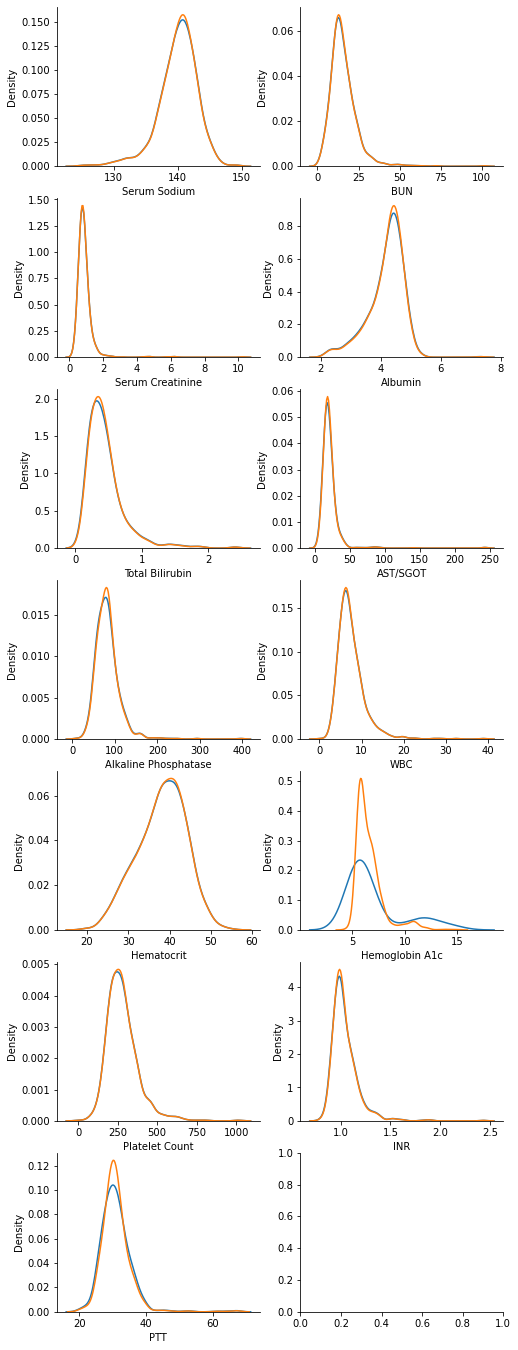

In [170]:
"""Let's compare the distributions of the original data to the imputed data."""

imputed_colorectal.columns = imputed_colorectal.columns.str.replace('_', ' ')

fig,axs = plt.subplots(nrows = 7, ncols = 2, figsize = (8,24))
for col, ax in zip(lab_tests, axs.ravel()):
    sns.kdeplot(x = col, 
                  data = merged_colorectal,
                  ax = ax,
                label = 'Original')
    sns.kdeplot(x = col, 
                  data = imputed_colorectal,
                  ax = ax,
                label = 'Imputed')

sns.despine()
plt.show()

In [171]:
# Concatenate imputed dataframe and LOS column

imputed_colorectal = pd.concat([imputed_colorectal, 
                                merged_colorectal['Hospital Length of Stay']],
                                axis = 1)

In [172]:
# Bin complications

imputed_colorectal['Summed Complications'] = np.round(imputed_colorectal[complications_cols].sum(axis = 1))
imputed_colorectal['Binned Complications'] = imputed_colorectal['Summed Complications'].apply(bin_complications)

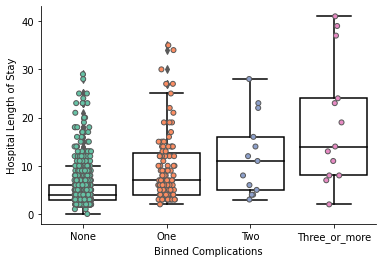

In [173]:
props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}}
sns.boxplot(x = imputed_colorectal['Binned Complications'], 
            y = 'Hospital Length of Stay', 
            data = merged_colorectal, 
            color = 'white',
            **props, palette = 'Set2',
            order = ['None','One','Two','Three_or_more'])
sns.stripplot(x = imputed_colorectal['Binned Complications'], 
            y = 'Hospital Length of Stay',
              data = merged_colorectal, 
              palette = 'Set2',
              linewidth = 1,
              order = ['None','One','Two','Three_or_more'])
#plt.xticks(rotation = 60)
sns.despine()
plt.show()

In [174]:
# Replace spaces in column names with '_' for compatibility with Patsy
imputed_colorectal.columns = imputed_colorectal.columns.str.replace(' ', '_')

In [195]:
"""Let's fit a negative binomial regression model to the imputed dataset."""

# formula, in statsmodels format, using Patsy 
expr = """ Hospital_Length_of_Stay ~ Albumin + INR  + Hematocrit + C(Race, Treatment(1)) + C(Binned_Complications) +
C(Open_or_Laparoscopic) + C(Functionally_Indpdnt_or_Dpdnt) + Age + C(Heart_Failure)  + C(History_of_Severe_COPD) + 
C(Has_Sepsis) """


NB2_reg = glm(expr,  
            data = imputed_colorectal,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 0.36
            family = sm.families.NegativeBinomial(alpha = 0.36)).fit()

print(NB2_reg.summary2())

                                    Results: Generalized linear model
Model:                           GLM                                AIC:                       3992.8361 
Link Function:                   log                                BIC:                       -4628.3390
Dependent Variable:              Hospital_Length_of_Stay            Log-Likelihood:            -1979.4   
Date:                            2022-08-26 00:53                   LL-Null:                   -2130.7   
No. Observations:                780                                Deviance:                  452.70    
Df Model:                        16                                 Pearson chi2:              621.      
Df Residuals:                    763                                Scale:                     1.0000    
Method:                          IRLS                                                                    
----------------------------------------------------------------------------------

In [176]:
df_for_model = imputed_colorectal

In [179]:
# Creating kfold column and intiate it with a dummy value
df_for_model["kfold"] = -1

# for loop to create the k-folds
kf = KFold(n_splits = 10, shuffle = True)
for fold, (train_indicies, test_indicies) in enumerate(kf.split(X = df_for_model)):
    df_for_model.loc[test_indicies, "kfold"] = fold

NB2_summaries = {}
NB2_test_predictions = []
NB2_training_predictions = []
NB2_test_RMSEs = []
NB2_train_RMSEs = []

Poisson_summaries = {}
Poisson_test_predictions = []
Poisson_training_predictions = []
Poisson_test_RMSEs = []
Poisson_train_RMSEs = []

for i in range(10):
    y_train, x_train = dmatrices(expr, 
                                df_for_model[df_for_model['kfold'] != i],
                                return_type = 'dataframe')
    y_test, x_test = dmatrices(expr, 
                               df_for_model[df_for_model['kfold'] == i], 
                               return_type = 'dataframe')
        
    x_train, x_test = x_train.align(x_test, join = 'outer', axis = 1, fill_value = 0)
    
    # Fit negative binomial regression model
    NB2_model = sm.GLM(y_train, 
                       x_train, 
                       family = sm.families.NegativeBinomial(alpha = 0.3636)).fit() 
    NB2_summaries[i] = NB2_model.summary2()
    
    #Generate predictions on test set
    NB2_test_predicted = NB2_model.get_prediction(x_test)
    NB2_test_predictions.append(NB2_test_predicted)
    
    #Generate predictions on train set
    NB2_training_predicted = NB2_model.get_prediction(x_train)
    NB2_training_predictions.append(NB2_training_predicted)
    
    #Calculate RMSE for test fold
    NB2_test_RMSE = RMSE(NB2_test_predicted.summary_frame()['mean'],
                         y_test['Hospital_Length_of_Stay'])
    NB2_test_RMSEs.append(NB2_test_RMSE)    

    #Calculate RMSE for training folds
    NB2_train_RMSE = RMSE(NB2_training_predicted.summary_frame()['mean'],
                          y_train['Hospital_Length_of_Stay'])
    NB2_train_RMSEs.append(NB2_train_RMSE)

In [180]:
#Negative binomial regression model 
NB2_mean_test_RMSE = (np.sum(NB2_test_RMSEs) / len(NB2_test_RMSEs))
NB2_mean_train_RMSE = (np.sum(NB2_train_RMSEs)/len(NB2_train_RMSEs))

print(f" The average RMSE for NB2 model predictions on test folds = {NB2_mean_test_RMSE}")
print(f" The average RMSE for NB2 model predictions on training folds  = {NB2_mean_train_RMSE}")

 The average RMSE for NB2 model predictions on test folds = 4.5019029719440296
 The average RMSE for NB2 model predictions on training folds  = 4.343786358655832


Data imputation with MissingForest allowed use of data from an additional 100 patients, and reduced RMSE on the test
folds.

In [192]:
NB2_regularized = glm(expr,  
            data = imputed_colorectal,
            # Fit data with a negative binomial regression, using the log link function, and dispersion
            # parameter of 0.36
            family = sm.families.NegativeBinomial(alpha = 0.36))
results = NB2_regularized.fit_regularized(method='elastic_net', 
                                                                                 alpha=0.0, 
                                                                                 start_params=None, 
                                                                                 refit=False)
results.summary()

NotImplementedError: 